<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/models/base_models_v7_ames_adaptive_multi_expert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# V7-AMES: Adaptive Multi-Expert Ensemble System for Monthly Precipitation Prediction

## Physics-Guided Mixture of Experts with 3-Stage Training

**Version:** 7.0.0  
**Date:** January 2026  
**Last Updated:** 2026-01-18  
**Author:** Manuel Ricardo Perez Reyes  
**Institution:** UPTC - Doctoral Thesis in Engineering  

**Changelog:**
- v7.0.0 (2026-01-18): V7-AMES notebook aligned to V5 pipeline structure and features
- v7.0.0 (2026-01-15): Initial V7-AMES architecture and 3-stage training

---

### Architecture Overview

V7-AMES combines three specialized experts with physics-guided routing and a physics-informed meta-learner:

| Component | Description | Role |
|-----------|-------------|------|
| **Expert 1 (High Elevation)** | GNN-TAT specialist | Orographic precipitation |
| **Expert 2 (Low Elevation)** | ConvLSTM specialist | Convective patterns |
| **Expert 3 (Transition)** | Hybrid GNN + Conv | Mixed regime |
| **Physics-Guided Gating** | Routing with orographic priors | Expert selection |
| **Physics-Informed Meta** | Residual + physics correction | Final prediction |

### Expected Performance (from V7-AMES README)

| Metric | V4 Baseline | V7 Conservative | V7 Optimistic |
|--------|-------------|----------------|--------------|
| R2 | 0.597 | 0.67-0.70 | 0.72-0.75 |
| RMSE (mm) | 84.40 | 76-79 | 72-75 |
| Parameters | 98K | ~400K | ~400K |

### Training Protocol

1. Stage 1: Pre-train Experts (high, low, transition)
2. Stage 2: Train Gating Network (experts frozen)
3. Stage 3: Joint Fine-Tuning with physics-informed loss


## 1. Environment Setup and Imports


In [1]:
# =============================================================================
# SECTION 1.1: ENVIRONMENT DETECTION AND SETUP
# =============================================================================

import os
import sys
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

if IN_COLAB:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Install required packages (match PyTorch/CUDA build)
    import torch

    torch_version = torch.__version__.split('+')[0]
    cuda_version = torch.version.cuda
    if cuda_version:
        cuda_tag = f"cu{cuda_version.replace('.', '')}"
    else:
        cuda_tag = "cpu"
    pyg_url = f"https://data.pyg.org/whl/torch-{torch_version}+{cuda_tag}.html"
    print(f"Installing PyG wheels from: {pyg_url}")
    # Removed -q for more verbose output to debug potential installation issues
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f {pyg_url}
    !pip install netCDF4 xarray dask h5netcdf

    # Verify torch_geometric installation
    try:
        import torch_geometric
        print("torch_geometric installed successfully.")
    except ImportError:
        print("ERROR: torch_geometric failed to install. Please check the output above for errors.")
        # Optionally, sys.exit(1) or raise ImportError here if torch_geometric is critical

    # Set base paths for Colab
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    DRIVE_DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
    LOCAL_DATA_FILE = Path('/content/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc')
    OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / 'V7_AMES'

    # Copy dataset to local for faster access
    if not LOCAL_DATA_FILE.exists():
        !cp "{DRIVE_DATA_FILE}" "{LOCAL_DATA_FILE}"
        print("Dataset copied to local storage for faster access")
    DATA_FILE = LOCAL_DATA_FILE
else:
    # Local paths
    BASE_PATH = Path('d:/github.com/ninja-marduk/ml_precipitation_prediction')
    DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
    OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / 'V7_AMES'

# Create output directories
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_ROOT}")


Running in Google Colab: True
Mounted at /content/drive
Installing PyG wheels from: https://data.pyg.org/whl/torch-2.9.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.9.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3869129 sha256=569422d657bf64c501cef5f532482bed4464434f98fead5471a989d24e7d663c
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800

In [2]:
# =============================================================================
# SECTION 1.2: IMPORTS
# =============================================================================

import json
import gc
import copy
import warnings
from datetime import datetime
from dataclasses import dataclass, field, asdict
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd
import xarray as xr

def ensure_matplotlib():
    """Ensures matplotlib is properly installed and importable."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        return plt, sns
    except AttributeError as e:
        if "get_data_path" in str(e):
            print("[WARN] Matplotlib cache corrupted. Attempting fix...")
            import sys
            import subprocess
            import shutil
            from pathlib import Path

            # Clear matplotlib cache
            try:
                import matplotlib
                cache_dir = Path(matplotlib.get_cachedir())
                if cache_dir.exists():
                    shutil.rmtree(cache_dir, ignore_errors=True)
                    print(f"[INFO] Cleared matplotlib cache: {cache_dir}")
            except Exception:
                pass

            # Reinstall matplotlib
            try:
                print("[INFO] Reinstalling matplotlib...")
                subprocess.check_call([
                    sys.executable, "-m", "pip", "install",
                    "--force-reinstall", "--no-cache-dir",
                    "matplotlib", "seaborn"
                ])
                print("[INFO] Matplotlib reinstalled. Please restart the kernel.")
            except Exception as install_exc:
                print(f"[ERROR] Reinstall failed: {install_exc}")

            raise RuntimeError(
                "Matplotlib installation corrupted. "
                "Please restart the kernel and rerun the cell."
            )
        else:
            raise

plt, sns = ensure_matplotlib()

try:
    import geopandas as gpd
except ImportError:
    gpd = None

try:
    import imageio.v2 as imageio
except ImportError:
    imageio = None


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


def ensure_torch_geometric() -> bool:
    """
    Ensures torch_geometric is installed with compatible versions.

    Returns:
        bool: True if successful, False otherwise
    """
    try:
        import torch_geometric  # noqa: F401
        return True
    except Exception:
        pass

    import sys
    import subprocess

    torch_ver = torch.__version__.split("+")[0]
    cuda_ver = torch.version.cuda
    if cuda_ver:
        cuda_tag = "cu" + cuda_ver.replace(".", "")
    else:
        cuda_tag = "cpu"

    url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html"
    pkgs = [
        "torch-scatter",
        "torch-sparse",
        "torch-cluster",
        "torch-spline-conv",
        "torch-geometric",
    ]

    print(f"[INFO] Installing PyG for torch={torch_ver}, cuda={cuda_tag}")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", url])
        return True
    except Exception as exc:
        print(f"[WARN] PyG install failed: {exc}")

    if cuda_tag != "cpu":
        url_cpu = f"https://data.pyg.org/whl/torch-{torch_ver}+cpu.html"
        print(f"[INFO] Retrying CPU wheels: {url_cpu}")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", url_cpu])
            print("[WARN] Installed CPU wheels; GPU will be disabled.")
            return True
        except Exception as exc:
            print(f"[ERROR] PyG CPU install failed: {exc}")

    return False


if not ensure_torch_geometric():
    raise RuntimeError("torch_geometric not available. Restart runtime and rerun.")

# PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data, Batch

from sklearn.cluster import KMeans
from scipy import stats

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42

def seed_everything(seed: int) -> bool:
    """
    Sets random seeds for reproducibility across libraries.

    Args:
        seed: Random seed value

    Returns:
        bool: True if CUDA seeding succeeded, False otherwise
    """
    np.random.seed(seed)

    cuda_ok = False
    if torch.cuda.is_available():
        try:
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            cuda_ok = True
        except Exception as exc:
            print(f"[WARN] CUDA seed failed: {exc}")

    return cuda_ok

# Initialize seeds and check CUDA status
CUDA_READY = seed_everything(SEED)
USE_CUDA = torch.cuda.is_available() and CUDA_READY

# Device configuration
device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f"Using device: {device}")

if USE_CUDA:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
elif torch.cuda.is_available() and not CUDA_READY:
    print("[WARN] CUDA is available but in a bad state. Using CPU instead.")
    print("[WARN] Consider restarting the runtime if GPU is needed.")
else:
    print("[INFO] CUDA not available. Using CPU.")


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB
CUDA Version: 12.6


## 2. Configuration


In [3]:
# =============================================================================
# SECTION 2: V7-AMES CONFIGURATION
# =============================================================================

@dataclass
class V7Config:
    """Complete V7-AMES configuration."""

    # Data configuration
    input_window: int = 60      # Input months
    horizon: int = 12           # Prediction months
    train_val_split: float = 0.8

    # Light mode for testing
    light_mode: bool = False     # Set to False for full grid
    light_grid_size: int = 5    # Grid subset size when light_mode=True

    # Enabled horizons for experiments
    enabled_horizons: List[int] = field(default_factory=lambda: [12])

    # Grid shape (updated after dataset load)
    n_lat: int = 61
    n_lon: int = 65
    n_nodes: int = 61 * 65

    # Expert 2: ConvLSTM configuration (V2 Enhanced style)
    convlstm_filters: List[int] = field(default_factory=lambda: [32, 16])
    convlstm_kernel_size: int = 3
    convlstm_attention: bool = True
    convlstm_bidirectional: bool = True
    convlstm_residual: bool = True
    convlstm_output_dim: int = 64

    # Expert 1: GNN-TAT configuration (V4 style)
    gnn_type: str = 'GAT'           # GAT, SAGE, or GCN
    gnn_hidden_dim: int = 64
    gnn_num_layers: int = 3
    gnn_num_heads: int = 4          # For GAT
    gnn_temporal_heads: int = 4
    gnn_lstm_hidden: int = 64
    gnn_lstm_layers: int = 2
    gnn_output_dim: int = 64
    gnn_dropout: float = 0.1
    use_temporal_attention: bool = True
    temporal_num_heads: int = 4

    # Expert 3: Hybrid configuration
    hybrid_gnn_hidden: int = 32
    hybrid_conv_hidden: int = 32
    hybrid_conv_layers: int = 2
    hybrid_dropout: float = 0.2

    # Physics-guided gating
    gating_hidden_dim: int = 32
    gating_dropout: float = 0.2
    physics_prior_weight_init: float = 0.3
    gating_diversity_lambda: float = 0.01

    # Meta-learner
    meta_hidden_dim: int = 64
    meta_hidden_dim2: int = 32
    meta_dropout: float = 0.2
    meta_use_context_features: bool = True

    # Training
    epochs_stage1: int = 50
    epochs_stage2: int = 30
    epochs_stage3: int = 50
    batch_size: int = 8
    lr_stage1: float = 0.001
    lr_stage2: float = 0.001
    lr_stage3: float = 0.0001
    weight_decay: float = 1e-4
    patience_stage1: int = 15
    patience_stage2: int = 10
    patience_stage3: int = 15
    gradient_clip: float = 1.0
    validate: bool = False

    # Physics loss weights
    lambda_mass_conservation: float = 0.05
    lambda_orographic: float = 0.1

    # Elevation thresholds (meters)
    low_elev_threshold: float = 2000.0
    high_elev_threshold: float = 3000.0
    medium_elev_min: float = 2000.0
    medium_elev_max: float = 3000.0

    # Graph construction
    edge_threshold: float = 0.3
    max_neighbors: int = 8
    use_distance_edges: bool = True
    use_elevation_edges: bool = True
    use_correlation_edges: bool = True
    distance_scale_km: float = 10.0
    elevation_weight: float = 0.3
    correlation_weight: float = 0.5
    elevation_scale_m: float = 500.0
    min_edge_weight: float = 0.01
    correlation_train_only: bool = True

    # Export/visualization alignment
    export_predictions: bool = True
    generate_map_plots: bool = True
    map_cycle_all_val_windows: bool = False
    map_sample_index: int = -1
    map_export_dpi: int = 300
    map_gif_duration: float = 1.5
    plot_graph_diagnostics: bool = True

    # Quality checks / gates
    max_bias_pct: float = 10.0
    max_scale_ratio: float = 50.0
    max_negative_frac: float = 0.001
    min_expert_weight: float = 0.05
    param_budget: int = 400000
    enforce_quality_gates: bool = False
    allow_missing_features: bool = False
    allow_overlap_windows: bool = False

    # Model sizing
    compact_model: bool = False

    # Device
    device: torch.device = device

# Initialize config
CONFIG = V7Config()

# Run-mode overrides
RUN_FULL_DATASET = True  # Set False for quick smoke tests
if RUN_FULL_DATASET:
    CONFIG.light_mode = False
    CONFIG.enabled_horizons = [12]
    CONFIG.horizon = 12

if CONFIG.compact_model:
    CONFIG.convlstm_filters = [16, 8]
    CONFIG.convlstm_output_dim = 32
    CONFIG.gnn_hidden_dim = 32
    CONFIG.gnn_num_heads = 2
    CONFIG.gnn_temporal_heads = 2
    CONFIG.gnn_lstm_hidden = 32
    CONFIG.gnn_output_dim = 32
    CONFIG.meta_hidden_dim = 48
    CONFIG.meta_hidden_dim2 = 24
    CONFIG.hybrid_gnn_hidden = 24
    CONFIG.hybrid_conv_hidden = 24

print("V7 Configuration initialized:")
print(f"  - Light mode: {CONFIG.light_mode}")
print(f"  - GNN type: {CONFIG.gnn_type}")
print(f"  - Enabled horizons: {CONFIG.enabled_horizons}")
print(f"  - Stage 1 epochs: {CONFIG.epochs_stage1}")
print(f"  - Stage 2 epochs: {CONFIG.epochs_stage2}")
print(f"  - Stage 3 epochs: {CONFIG.epochs_stage3}")


V7 Configuration initialized:
  - Light mode: False
  - GNN type: GAT
  - Enabled horizons: [12]
  - Stage 1 epochs: 50
  - Stage 2 epochs: 30
  - Stage 3 epochs: 50


## 3. Data Loading and Validation


In [4]:
# =============================================================================
# SECTION 3: DATA LOADING AND FEATURE EXTRACTION
# =============================================================================

# Feature set definitions
FEATURE_SETS = {
    'BASIC': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect'
    ],
    'KCE': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect',
        'elev_high', 'elev_med', 'elev_low'
    ],
    'PAFC': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect',
        'elev_high', 'elev_med', 'elev_low',
        'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12'
    ]
}

def _resolve_dim(ds: xr.Dataset, candidates: Tuple[str, ...]) -> str:
    for name in candidates:
        if name in ds.dims:
            return name
    raise ValueError(f"Missing required dimension. Expected one of: {candidates}")


def _required_features(feature_sets: Dict[str, List[str]]) -> List[str]:
    required = set()
    for name in feature_sets['BASIC'] + feature_sets['KCE']:
        if name.startswith('elev_'):
            continue
        required.add(name)
    required.add('total_precipitation')
    return sorted(required)


def validate_dataset(ds: xr.Dataset, config: V7Config, feature_sets: Dict[str, List[str]]) -> Tuple[str, str]:
    if 'time' not in ds.dims:
        raise ValueError("Dataset missing required 'time' dimension")

    lat_dim = _resolve_dim(ds, ('latitude', 'lat'))
    lon_dim = _resolve_dim(ds, ('longitude', 'lon'))

    missing = [name for name in _required_features(feature_sets)
               if name not in ds.data_vars and name not in ds.coords]
    if missing:
        raise ValueError(f"Missing required variables: {missing}")

    n_time = int(ds.dims['time'])
    if n_time < config.input_window + config.horizon:
        raise ValueError(
            f"Not enough timesteps: {n_time} < {config.input_window + config.horizon}"
        )

    return lat_dim, lon_dim


def load_dataset(data_path: Path, config: V7Config) -> xr.Dataset:
    """Load and validate the NetCDF dataset."""
    print(f"Loading dataset from: {data_path}")
    ds = xr.open_dataset(data_path)

    lat_dim, lon_dim = validate_dataset(ds, config, FEATURE_SETS)

    # Print dataset info
    print(f"Dataset dimensions:")
    for dim, size in ds.dims.items():
        print(f"  - {dim}: {size}")

    print(f"Available variables: {list(ds.data_vars)}")

    # Apply light mode if enabled
    if config.light_mode:
        lat_slice = slice(0, config.light_grid_size)
        lon_slice = slice(0, config.light_grid_size)
        ds = ds.isel({lat_dim: lat_slice, lon_dim: lon_slice})
        print(f"Light mode enabled: using {config.light_grid_size}x{config.light_grid_size} grid")

    return ds


def create_elevation_clusters(ds: xr.Dataset, n_clusters: int = 3) -> xr.Dataset:
    """Add elevation cluster features (KCE) to dataset."""
    elevation = ds['elevation'].values
    elev_dims = ds['elevation'].dims

    # Handle 3D elevation (time, lat, lon) by taking first timestep
    if elevation.ndim == 3:
        print("Handling 3D elevation: using first timestep for static clustering")
        elevation = elevation[0]
        elev_dims = elev_dims[-2:]

    valid_mask = ~np.isnan(elevation)

    # Flatten for clustering
    elev_flat = elevation[valid_mask].reshape(-1, 1)

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    labels = np.full(elevation.shape, -1)
    labels[valid_mask] = kmeans.fit_predict(elev_flat)

    # Create one-hot encoded features
    for i, name in enumerate(['elev_low', 'elev_med', 'elev_high']):
        cluster_data = np.zeros_like(elevation)
        cluster_data[labels == i] = 1.0
        ds[name] = xr.DataArray(
            data=cluster_data,
            dims=elev_dims,
            attrs={'description': f'Elevation cluster {name}'}
        )

    print("Added elevation clusters: elev_low, elev_med, elev_high")
    return ds


def extract_features(ds: xr.Dataset, feature_names: List[str], config: V7Config) -> Tuple[np.ndarray, List[str]]:
    """Extract features from dataset into numpy array."""
    features = []
    missing = []

    for name in feature_names:
        if name in ds.data_vars:
            data = ds[name].values
            # Handle different dimensions
            if data.ndim == 2:  # (lat, lon) - static features
                # Broadcast to (time, lat, lon)
                data = np.broadcast_to(data, (ds.dims['time'], *data.shape))
            features.append(data)
        else:
            missing.append(name)

    if missing:
        msg = f"Missing features: {missing}"
        if config.allow_missing_features:
            print(f"Warning: {msg}")
        else:
            raise ValueError(msg)

    if not features:
        raise ValueError("No features extracted; check dataset and feature list")

    # Stack features: (time, lat, lon, n_features)
    features = np.stack(features, axis=-1)
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"Extracted features shape: {features.shape}")

    return features.astype(np.float32), missing


def build_context_features(ds: xr.Dataset, lat_dim: str, lon_dim: str) -> Tuple[np.ndarray, np.ndarray]:
    """Build static context features (elevation, slope, aspect, lat/lon)."""
    elevation = ds['elevation'].values
    if elevation.ndim == 3:
        elevation = elevation[0]

    if 'slope' in ds:
        slope = ds['slope'].values
        if slope.ndim == 3:
            slope = slope[0]
    else:
        grad_y, grad_x = np.gradient(elevation)
        slope = np.sqrt(grad_x**2 + grad_y**2)

    if 'aspect' in ds:
        aspect = ds['aspect'].values
        if aspect.ndim == 3:
            aspect = aspect[0]
    else:
        grad_y, grad_x = np.gradient(elevation)
        aspect = np.arctan2(grad_y, grad_x)

    aspect_sin = np.sin(aspect)
    aspect_cos = np.cos(aspect)

    lat_vals = ds[lat_dim].values
    lon_vals = ds[lon_dim].values
    lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')

    lat_norm = (lat_grid - np.mean(lat_grid)) / (np.std(lat_grid) + 1e-6)
    lon_norm = (lon_grid - np.mean(lon_grid)) / (np.std(lon_grid) + 1e-6)

    elev_norm = (elevation - np.mean(elevation)) / (np.std(elevation) + 1e-6)
    slope_norm = (slope - np.mean(slope)) / (np.std(slope) + 1e-6)

    context = np.stack(
        [elev_norm, slope_norm, aspect_sin, aspect_cos, lat_norm, lon_norm],
        axis=-1
    ).astype(np.float32)

    return context, elevation.astype(np.float32)

# Load dataset
DS = load_dataset(DATA_FILE, CONFIG)
LAT_DIM = _resolve_dim(DS, ('latitude', 'lat'))
LON_DIM = _resolve_dim(DS, ('longitude', 'lon'))
DS = create_elevation_clusters(DS)

CONFIG.n_lat = int(DS.dims[LAT_DIM])
CONFIG.n_lon = int(DS.dims[LON_DIM])
CONFIG.n_nodes = CONFIG.n_lat * CONFIG.n_lon

# Build context features and elevation masks
CONTEXT_STATIC, ELEVATION_GRID = build_context_features(DS, LAT_DIM, LON_DIM)
CONTEXT_NODES = CONTEXT_STATIC.reshape(-1, CONTEXT_STATIC.shape[-1])
ELEVATION_NODES = ELEVATION_GRID.reshape(-1)

MASK_HIGH = (ELEVATION_GRID >= CONFIG.high_elev_threshold)
MASK_LOW = (ELEVATION_GRID < CONFIG.low_elev_threshold)
MASK_MED = (ELEVATION_GRID >= CONFIG.medium_elev_min) & (ELEVATION_GRID <= CONFIG.medium_elev_max)

MASK_HIGH_NODES = MASK_HIGH.reshape(-1)
MASK_LOW_NODES = MASK_LOW.reshape(-1)
MASK_MED_NODES = MASK_MED.reshape(-1)

V7_DATA_DIR = OUTPUT_ROOT / 'data'
V7_DATA_DIR.mkdir(parents=True, exist_ok=True)
np.save(V7_DATA_DIR / 'mask_high.npy', MASK_HIGH.astype(np.float32))
np.save(V7_DATA_DIR / 'mask_medium.npy', MASK_MED.astype(np.float32))
np.save(V7_DATA_DIR / 'mask_low.npy', MASK_LOW.astype(np.float32))
np.save(V7_DATA_DIR / 'context_features_spatial.npy', CONTEXT_STATIC)

print("Context features saved to:", V7_DATA_DIR)
print("Mask summary:")
print(f"  High elevation: {int(MASK_HIGH.sum())} cells")
print(f"  Medium elevation: {int(MASK_MED.sum())} cells")
print(f"  Low elevation: {int(MASK_LOW.sum())} cells")

# Alias for compatibility with V5-style code
ds = DS


Loading dataset from: /content/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Dataset dimensions:
  - time: 518
  - latitude: 61
  - longitude: 65
Available variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36', 'CEEMDAN_imf_1', 'CEEMDAN_imf_2', 'CEEMDAN_imf_3', 'CEEMDAN_imf_4', 'CEEMDAN_imf_5', 'CEEMDAN_imf_6', 'CEEMDAN_imf_7', 'CEEMDAN_imf_8', 'CEEMDAN_imf_9', 'TVFEMD_imf_1', 'TVFEMD_imf_2', 'TVFEMD_imf_3', 'TVFEMD_imf_4', 'TVFEMD_imf_5', 'TVFEMD_imf_6', 'TVFEMD_imf_7', 'TVFEMD_imf_8', 'elev_low', 'elev_med', 'elev_high']
Handling 3D elevation: using first times

## 4. Graph Construction for GNN Experts


In [5]:
# =============================================================================
# SECTION 4: GRAPH CONSTRUCTION
# =============================================================================

class SpatialGraphBuilder:
    """Build spatial graph for GNN branch based on geographic and topographic similarity."""

    def __init__(self, config: V7Config):
        self.config = config

    @staticmethod
    def _safe_correlation(ts_a: np.ndarray, ts_b: np.ndarray) -> float:
        """Compute correlation robustly (returns 0.0 for invalid cases)."""
        mask = np.isfinite(ts_a) & np.isfinite(ts_b)
        if mask.sum() < 2:
            return 0.0
        a = ts_a[mask]
        b = ts_b[mask]
        a = a - a.mean()
        b = b - b.mean()
        denom = np.sqrt(np.sum(a * a)) * np.sqrt(np.sum(b * b))
        if denom < 1e-6:
            return 0.0
        corr = float(np.sum(a * b) / denom)
        if not np.isfinite(corr):
            return 0.0
        return corr

    @staticmethod
    def _get_coord(ds: xr.Dataset, names: List[str]) -> np.ndarray:
        for name in names:
            if name in ds.coords:
                return ds.coords[name].values
            if name in ds.variables:
                return ds[name].values
        raise KeyError(f"Missing coordinate; tried {names}")

    def build_graph(self, ds: xr.Dataset, train_time_idx: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Build graph structure from dataset.

        Returns:
            edge_index: (2, num_edges) tensor of edge indices
            edge_weight: (num_edges,) tensor of edge weights
        """
        lat = self._get_coord(ds, ['lat', 'latitude'])
        lon = self._get_coord(ds, ['lon', 'longitude'])
        elevation = ds['elevation'].values

        if elevation.ndim == 3:
            elevation = elevation[0]

        n_lat, n_lon = len(lat), len(lon)
        n_nodes = n_lat * n_lon

        print(f"Building graph for {n_lat}x{n_lon} = {n_nodes} nodes")

        # Create node positions in km for distance scaling
        lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
        mean_lat = float(np.mean(lat))
        km_per_deg_lat = 111.32
        km_per_deg_lon = 111.32 * np.cos(np.deg2rad(mean_lat))
        positions = np.stack(
            [lat_grid.flatten() * km_per_deg_lat, lon_grid.flatten() * km_per_deg_lon],
            axis=1
        )
        elev_flat = elevation.flatten()

        self.node_positions = positions
        self.node_elevations = elev_flat
        self.n_nodes = n_nodes

        # Precompute precipitation time series for correlation edges
        precip_flat = None
        if self.config.use_correlation_edges:
            precip = ds['total_precipitation'].values.astype(np.float32)
            if train_time_idx is not None:
                train_time_idx = max(2, min(train_time_idx, precip.shape[0]))
                precip = precip[:train_time_idx]
                print(f"Correlation edges using first {train_time_idx} timesteps")
            precip_flat = precip.reshape(precip.shape[0], n_nodes)

        edges = []
        weights = []

        distance_coeff = 1.0
        if self.config.use_elevation_edges or self.config.use_correlation_edges:
            distance_coeff = max(
                0.0,
                1.0 - self.config.elevation_weight - self.config.correlation_weight
            )

        for i in range(n_nodes):
            # Calculate distances to all other nodes
            distances = np.sqrt(np.sum((positions - positions[i])**2, axis=1))

            # Get k nearest neighbors (excluding self)
            distances[i] = np.inf
            nearest_idx = np.argsort(distances)[:self.config.max_neighbors]
            ts_i = precip_flat[:, i] if precip_flat is not None else None

            for j in nearest_idx:
                if distances[j] == np.inf:
                    continue

                component_weights = []

                if self.config.use_distance_edges:
                    dist_weight = np.exp(-distances[j] / self.config.distance_scale_km)
                    component_weights.append((dist_weight, distance_coeff))

                if self.config.use_elevation_edges:
                    if not np.isnan(elev_flat[i]) and not np.isnan(elev_flat[j]):
                        elev_diff = np.abs(elev_flat[i] - elev_flat[j])
                        elev_weight = np.exp(-elev_diff / self.config.elevation_scale_m)
                    else:
                        elev_weight = 0.5
                    component_weights.append((elev_weight, self.config.elevation_weight))

                if self.config.use_correlation_edges:
                    if precip_flat is not None:
                        corr = self._safe_correlation(ts_i, precip_flat[:, j])
                    else:
                        corr = 0.0
                    corr_weight = max(0.0, corr)
                    component_weights.append((corr_weight, self.config.correlation_weight))

                if not component_weights:
                    continue

                coeff_sum = sum(weight for _, weight in component_weights)
                if coeff_sum <= 0:
                    coeff_sum = len(component_weights)
                    combined_weight = sum(val for val, _ in component_weights) / coeff_sum
                else:
                    combined_weight = sum(val * weight for val, weight in component_weights) / coeff_sum

                threshold = max(self.config.edge_threshold, self.config.min_edge_weight)
                if combined_weight >= threshold:
                    edges.append([i, j])
                    weights.append(combined_weight)

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor(weights, dtype=torch.float32)

        print(f"Graph built: {n_nodes} nodes, {edge_index.shape[1]} edges")
        print(f"Average edges per node: {edge_index.shape[1] / n_nodes:.1f}")

        return edge_index, edge_weight

# Build graph
graph_builder = SpatialGraphBuilder(CONFIG)
train_time_idx = None
if CONFIG.use_correlation_edges and CONFIG.correlation_train_only:
    train_time_idx = int(ds.dims['time'] * CONFIG.train_val_split)
edge_index, edge_weight = graph_builder.build_graph(ds, train_time_idx=train_time_idx)
if edge_index.numel() == 0:
    raise ValueError("Graph construction produced zero edges")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge weight shape: {edge_weight.shape}")


Building graph for 61x65 = 3965 nodes
Correlation edges using first 414 timesteps
Graph built: 3965 nodes, 31720 edges
Average edges per node: 8.0
Edge index shape: torch.Size([2, 31720])
Edge weight shape: torch.Size([31720])


Graph visualization saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/graph_visualization_v7.png


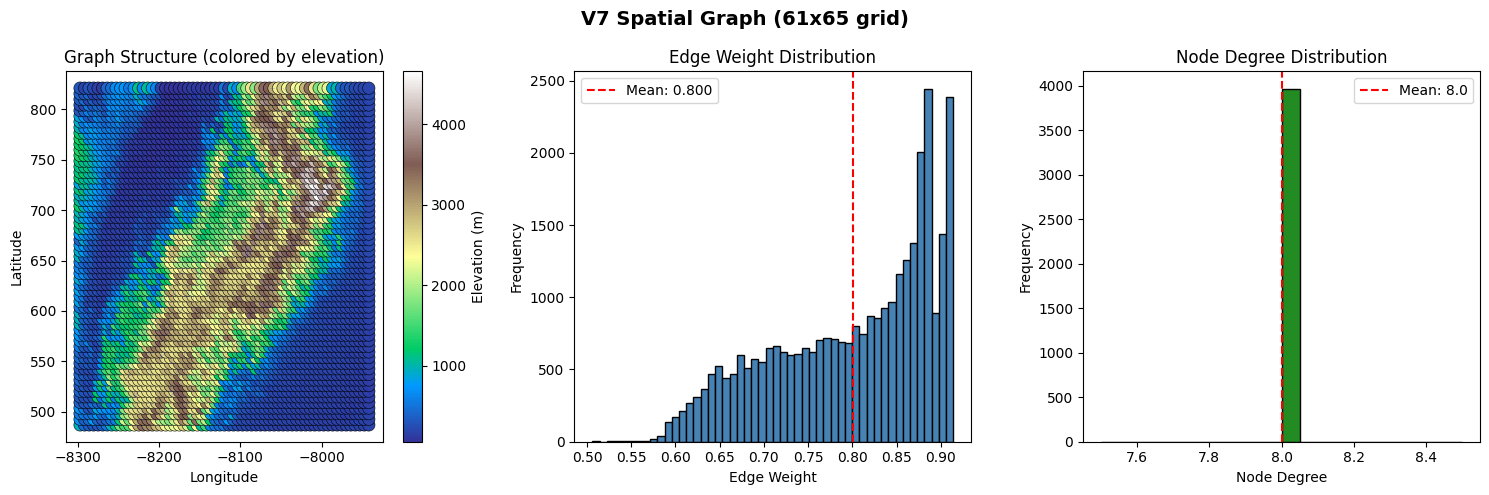

Edge analysis saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/graph_edge_analysis_v5.png


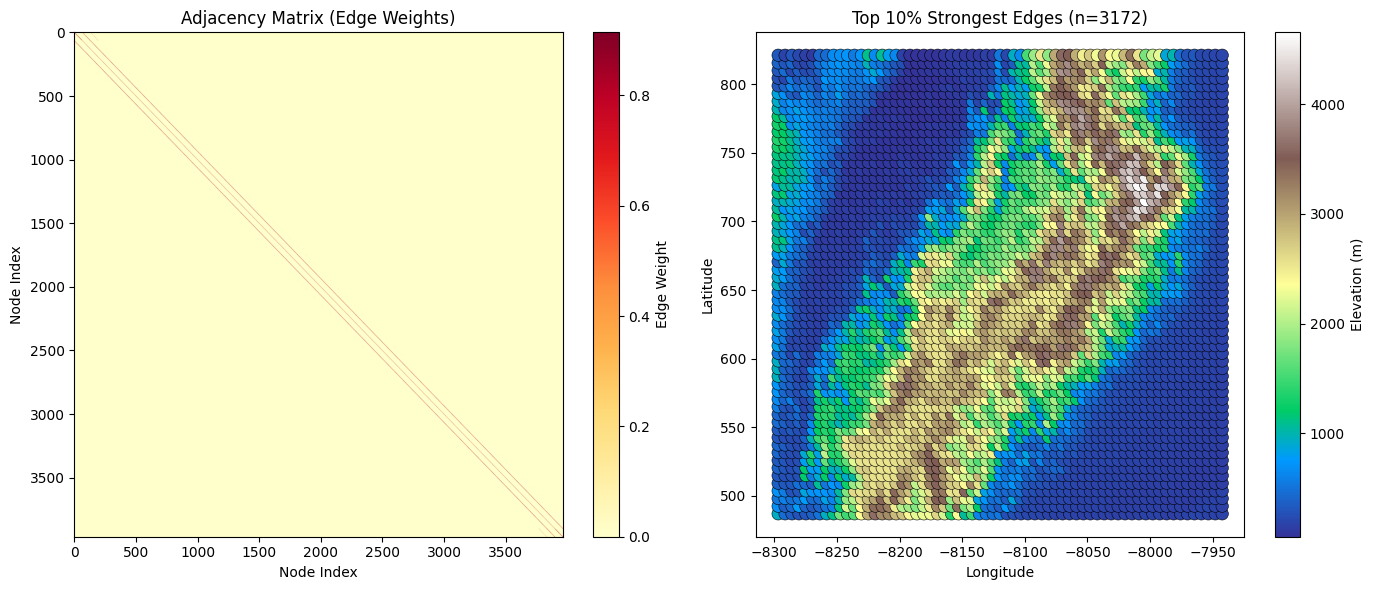

Graph Statistics:
  Total nodes: 3965
  Total edges: 31720
  Average edge weight: 0.8005
  Max edge weight: 0.9141
  Strong edges (top 10%): 3172


In [6]:
# =============================================================================
# SECTION 4.1: GRAPH DIAGNOSTICS (V4-COMPATIBLE)
# =============================================================================

def visualize_graph(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                   edge_weight: np.ndarray, title: str = 'Spatial Graph'):
    if edge_weight.size == 0:
        print('Graph visualization skipped: empty edge list')
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    pos = graph_builder.node_positions
    n_edges_to_draw = min(500, len(edge_weight))
    edge_indices = np.random.choice(len(edge_weight), n_edges_to_draw, replace=False)
    for idx in edge_indices:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax1.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]], 'b-', alpha=0.2, linewidth=0.5)

    scatter = ax1.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=80, edgecolors='black', linewidth=0.4)
    plt.colorbar(scatter, ax=ax1, label='Elevation (m)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Graph Structure (colored by elevation)')

    ax2 = axes[1]
    ax2.hist(edge_weight, bins=50, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Edge Weight')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Edge Weight Distribution')
    ax2.axvline(np.mean(edge_weight), color='red', linestyle='--', label=f'Mean: {np.mean(edge_weight):.3f}')
    ax2.legend()

    ax3 = axes[2]
    degrees = np.bincount(edge_index[0], minlength=graph_builder.n_nodes)
    ax3.hist(degrees, bins=20, color='forestgreen', edgecolor='black')
    ax3.set_xlabel('Node Degree')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Node Degree Distribution')
    ax3.axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
    ax3.legend()

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    fig_path = OUTPUT_ROOT / 'graph_visualization_v7.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Graph visualization saved to: {fig_path}")
    plt.show()


def analyze_graph_edges(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                        edge_weight: np.ndarray, output_dir: Path):
    if edge_weight.size == 0:
        print('Graph edge analysis skipped: empty edge list')
        return

    max_nodes_for_adj = 6000
    if graph_builder.n_nodes > max_nodes_for_adj:
        print(f"Skipping adjacency matrix plot: {graph_builder.n_nodes} nodes")
        fig, ax = plt.subplots(1, 1, figsize=(7, 6))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if len(axes) > 1:
        ax1 = axes[0]
        adj_matrix = np.zeros((graph_builder.n_nodes, graph_builder.n_nodes), dtype=np.float32)
        for idx in range(len(edge_weight)):
            i, j = edge_index[0, idx], edge_index[1, idx]
            adj_matrix[i, j] = edge_weight[idx]
        im1 = ax1.imshow(adj_matrix, cmap='YlOrRd', aspect='auto')
        plt.colorbar(im1, ax=ax1, label='Edge Weight')
        ax1.set_xlabel('Node Index')
        ax1.set_ylabel('Node Index')
        ax1.set_title('Adjacency Matrix (Edge Weights)')
        ax2 = axes[1]
    else:
        ax2 = axes[0]

    threshold = np.percentile(edge_weight, 90)
    strong_edges = edge_weight > threshold
    pos = graph_builder.node_positions

    scatter = ax2.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=80, edgecolors='black', linewidth=0.4, zorder=2)
    plt.colorbar(scatter, ax=ax2, label='Elevation (m)')

    for idx in np.where(strong_edges)[0]:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax2.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]],
                'r-', alpha=0.6, linewidth=edge_weight[idx] * 2, zorder=1)

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title(f'Top 10% Strongest Edges (n={int(strong_edges.sum())})')

    plt.tight_layout()

    fig_path = output_dir / 'graph_edge_analysis_v5.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Edge analysis saved to: {fig_path}")
    plt.show()

    print('Graph Statistics:')
    print(f"  Total nodes: {graph_builder.n_nodes}")
    print(f"  Total edges: {len(edge_weight)}")
    print(f"  Average edge weight: {np.mean(edge_weight):.4f}")
    print(f"  Max edge weight: {np.max(edge_weight):.4f}")
    print(f"  Strong edges (top 10%): {int(strong_edges.sum())}")


if getattr(CONFIG, 'plot_graph_diagnostics', True):
    edge_index_np = edge_index.cpu().numpy()
    edge_weight_np = edge_weight.cpu().numpy()
    try:
        visualize_graph(
            graph_builder, edge_index_np, edge_weight_np,
            title=f"V7 Spatial Graph ({int(ds.dims[LAT_DIM])}x{int(ds.dims[LON_DIM])} grid)"
        )
    except Exception as exc:
        print(f"Graph visualization skipped: {exc}")
    try:
        analyze_graph_edges(graph_builder, edge_index_np, edge_weight_np, OUTPUT_ROOT)
    except Exception as exc:
        print(f"Graph edge analysis skipped: {exc}")


## 5. Data Preprocessing Pipeline


In [7]:
# =============================================================================
# SECTION 5: DATA PREPROCESSING AND DATASET CLASS
# =============================================================================

def create_temporal_windows(
    features: np.ndarray,
    target: np.ndarray,
    input_window: int,
    horizon: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Create temporal windows for sequence-to-sequence prediction.

    Note: This is memory-heavy for full grids and kept for debugging only.
    """
    n_time = features.shape[0]
    n_samples = n_time - input_window - horizon + 1

    if n_samples <= 0:
        raise ValueError(f"Not enough timesteps: {n_time} < {input_window + horizon}")

    X_list = []
    Y_list = []

    for i in range(n_samples):
        X_list.append(features[i:i+input_window])
        Y_list.append(target[i+input_window:i+input_window+horizon])

    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)

    print(f"Created {n_samples} samples")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")

    return X, Y

class V7DualBranchDataset(Dataset):
    """Dataset for V7-AMES dual-branch input (grid + graph)."""

    def __init__(
        self,
        features_grid: torch.Tensor,  # (time, lat, lon, features)
        features_graph: torch.Tensor, # (time, lat, lon, features)
        target: torch.Tensor,         # (time, lat, lon)
        input_window: int,
        horizon: int,
        edge_index: torch.Tensor,
        edge_weight: torch.Tensor,
        context_nodes: torch.Tensor,  # (n_nodes, context_dim)
        elevation_nodes: torch.Tensor, # (n_nodes,)
        start_idx: int,
        end_idx: int
    ):
        self.features_grid = features_grid
        self.features_graph = features_graph
        self.target = target
        self.input_window = input_window
        self.horizon = horizon
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.context_nodes = context_nodes
        self.elevation_nodes = elevation_nodes
        self.start_idx = start_idx
        self.end_idx = end_idx

        if end_idx <= start_idx:
            raise ValueError(f"Invalid window range: {start_idx} to {end_idx}")

        # Store grid dimensions for later use
        self.n_lat = features_grid.shape[1]
        self.n_lon = features_grid.shape[2]
        self.n_nodes = self.n_lat * self.n_lon

        max_start = target.shape[0] - input_window - horizon
        if max_start < 0:
            raise ValueError(
                f"Not enough timesteps: {target.shape[0]} < {input_window + horizon}"
            )
        if self.start_idx < 0 or self.end_idx - 1 > max_start:
            raise ValueError(
                f"Window range out of bounds: {self.start_idx}..{self.end_idx - 1} > {max_start}"
            )

    def __len__(self):
        return self.end_idx - self.start_idx

    def __getitem__(self, idx):
        i = self.start_idx + idx
        x_grid = self.features_grid[i:i+self.input_window]
        x_graph = self.features_graph[i:i+self.input_window]
        y = self.target[i+self.input_window:i+self.input_window+self.horizon]

        return {
            'x_grid': x_grid,
            'x_graph': x_graph.reshape(
                self.input_window, -1, x_graph.shape[-1]
            ),
            'y': y,
            'context': self.context_nodes,
            'elevation': self.elevation_nodes,
            'edge_index': self.edge_index,
            'edge_weight': self.edge_weight
        }


def prepare_data(
    ds: xr.Dataset,
    config: V7Config,
    edge_index: torch.Tensor,
    edge_weight: torch.Tensor,
    context_nodes: np.ndarray,
    elevation_nodes: np.ndarray,
    feature_set_grid: str = 'BASIC',
    feature_set_graph: str = 'KCE'
):
    """Prepare data for V7 training."""
    print("" + "="*60)
    print("Preparing data for V7-AMES")
    print("="*60)

    # Extract features for both branches
    print(f"Extracting {feature_set_grid} features (ConvLSTM branch):")
    features_grid, missing_grid = extract_features(ds, FEATURE_SETS[feature_set_grid], config)

    print(f"Extracting {feature_set_graph} features (GNN branch):")
    features_graph, missing_graph = extract_features(ds, FEATURE_SETS[feature_set_graph], config)

    # Target variable
    target = ds['total_precipitation'].values.astype(np.float32)
    print(f"Target shape: {target.shape}")

    # Handle NaN values
    features_grid = np.nan_to_num(features_grid, nan=0.0)
    features_graph = np.nan_to_num(features_graph, nan=0.0)
    target = np.nan_to_num(target, nan=0.0)

    # Window counts (avoid materializing all windows)
    n_time = features_grid.shape[0]
    max_start = n_time - config.input_window - config.horizon
    if max_start < 0:
        raise ValueError(f"Not enough timesteps: {n_time} < {config.input_window + config.horizon}")
    n_samples = max_start + 1

    print("Computed temporal windows:")
    print(f"  Samples: {n_samples}")
    print(f"  Input window: {config.input_window}")
    print(f"  Horizon: {config.horizon}")

    # Train/val split by time BEFORE windowing (avoid leakage)
    min_split = config.input_window + config.horizon
    max_split = max_start
    split_mode = 'time'
    split_time_idx = int(n_time * config.train_val_split)

    if min_split > max_split:
        msg = (
            f"Not enough timesteps for leakage-free split: n_time={n_time}, "
            f"need >= {2 * (config.input_window + config.horizon)}"
        )
        if config.allow_overlap_windows:
            print(f"Warning: {msg}. Falling back to overlap-prone split.")
            split_mode = 'window'
            n_train = int(n_samples * config.train_val_split)
            n_val = n_samples - n_train
            train_last_start = n_train - 1
            val_start_idx = n_train
            val_last_start = max_start
            split_time_idx = val_start_idx
        elif config.enforce_quality_gates:
            raise ValueError(msg)
        else:
            raise ValueError(msg)
    else:
        if split_time_idx < min_split:
            print(f"Warning: split_time_idx={split_time_idx} < min_split={min_split}; clipping.")
            split_time_idx = min_split
        if split_time_idx > max_split:
            print(f"Warning: split_time_idx={split_time_idx} > max_split={max_split}; clipping.")
            split_time_idx = max_split

        train_last_start = split_time_idx - config.input_window - config.horizon
        val_start_idx = split_time_idx
        val_last_start = max_start
        n_train = train_last_start + 1
        n_val = val_last_start - val_start_idx + 1

    if n_train <= 0 or n_val <= 0:
        raise ValueError(f"Invalid train/val split: {n_train}/{n_val}")

    print("Split configuration:")
    print(f"  Split mode: {split_mode}")
    print(f"  Split index: {split_time_idx}")
    print(f"  Train window starts: 0..{train_last_start} ({n_train})")
    print(f"  Val window starts: {val_start_idx}..{val_last_start} ({n_val})")
    gap = val_start_idx - (train_last_start + 1)
    print(f"  Gap windows: {gap}")

    # Overlap leakage check
    last_train_end = train_last_start + config.input_window + config.horizon - 1
    first_val_start = val_start_idx
    overlap_leakage = last_train_end >= first_val_start
    if overlap_leakage:
        msg = "Train/val windows overlap. Consider splitting before windowing."
        if config.allow_overlap_windows:
            print(f"Warning: {msg}")
        elif config.enforce_quality_gates:
            raise ValueError(msg)
        else:
            print(f"Warning: {msg}")

    # Normalize using training input range only (avoid leakage)
    print("Normalizing features using training split only:")
    train_input_end = train_last_start + config.input_window - 1
    train_slice = slice(0, train_input_end + 1)

    grid_mean = features_grid[train_slice].mean(axis=(0, 1, 2), keepdims=True)
    grid_std = features_grid[train_slice].std(axis=(0, 1, 2), keepdims=True)
    grid_std = np.where(grid_std > 1e-6, grid_std, 1.0)

    graph_mean = features_graph[train_slice].mean(axis=(0, 1, 2), keepdims=True)
    graph_std = features_graph[train_slice].std(axis=(0, 1, 2), keepdims=True)
    graph_std = np.where(graph_std > 1e-6, graph_std, 1.0)

    features_grid = ((features_grid - grid_mean) / grid_std).astype(np.float32)
    features_graph = ((features_graph - graph_mean) / graph_std).astype(np.float32)

    # Convert to torch once to avoid repeated conversion in __getitem__
    features_grid_t = torch.from_numpy(features_grid)
    features_graph_t = torch.from_numpy(features_graph)
    target_t = torch.from_numpy(target)
    context_nodes_t = torch.from_numpy(context_nodes).float()
    elevation_nodes_t = torch.from_numpy(elevation_nodes).float()

    train_dataset = V7DualBranchDataset(
        features_grid_t, features_graph_t, target_t,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        context_nodes_t, elevation_nodes_t,
        start_idx=0,
        end_idx=n_train
    )
    val_dataset = V7DualBranchDataset(
        features_grid_t, features_graph_t, target_t,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        context_nodes_t, elevation_nodes_t,
        start_idx=val_start_idx,
        end_idx=val_last_start + 1
    )

    feature_index_map = {
        name: idx for idx, name in enumerate(FEATURE_SETS[feature_set_graph])
    }

    data_report = {
        'n_samples': int(n_samples),
        'n_train': int(n_train),
        'n_val': int(n_val),
        'n_time': int(n_time),
        'feature_set_grid': feature_set_grid,
        'feature_set_graph': feature_set_graph,
        'split_mode': split_mode,
        'split_time_idx': int(split_time_idx),
        'train_last_start': int(train_last_start),
        'val_start_idx': int(val_start_idx),
        'val_end_idx': int(val_last_start),
        'train_input_end': int(train_input_end),
        'overlap_leakage': bool(overlap_leakage),
        'missing_features_grid': missing_grid,
        'missing_features_graph': missing_graph,
        'context_dim': int(context_nodes.shape[-1])
    }

    print(f"Dataset split:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")

    return train_dataset, val_dataset, features_grid.shape[-1], features_graph.shape[-1], data_report, feature_index_map

# Prepare data
DEFAULT_FEATURE_SET_GRID = 'BASIC'
DEFAULT_FEATURE_SET_GRAPH = 'KCE'

train_dataset, val_dataset, n_features_grid, n_features_graph, data_report, FEATURE_INDEX = prepare_data(
    DS, CONFIG, edge_index, edge_weight,
    context_nodes=CONTEXT_NODES,
    elevation_nodes=ELEVATION_NODES,
    feature_set_grid=DEFAULT_FEATURE_SET_GRID,
    feature_set_graph=DEFAULT_FEATURE_SET_GRAPH
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.batch_size, shuffle=False)

print(f"Data loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Preparing data for V7-AMES
Extracting BASIC features (ConvLSTM branch):
Extracted features shape: (518, 61, 65, 12)
Extracting KCE features (GNN branch):
Extracted features shape: (518, 61, 65, 15)
Target shape: (518, 61, 65)
Computed temporal windows:
  Samples: 447
  Input window: 60
  Horizon: 12
Split configuration:
  Split mode: time
  Split index: 414
  Train window starts: 0..342 (343)
  Val window starts: 414..446 (33)
  Gap windows: 71
Normalizing features using training split only:
Dataset split:
  Training samples: 343
  Validation samples: 33
Data loaders created:
  Train batches: 43
  Val batches: 5


## 6. V7-AMES Model Architecture


In [8]:
# =============================================================================
# SECTION 6.1: EXPERT 2 - CONVLSTM (LOW ELEVATION)
# =============================================================================

class ConvLSTMCell(nn.Module):
    """Single ConvLSTM cell with spatial convolutions."""

    def __init__(self, input_dim: int, hidden_dim: int, kernel_size: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # i, f, o, g gates
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]):
        h, c = state
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.split(gates, self.hidden_dim, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

    def init_hidden(self, batch_size: int, height: int, width: int, device: torch.device):
        return (
            torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=device)
        )

class SpatialAttention(nn.Module):
    """Spatial attention mechanism for ConvLSTM output."""

    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attention = torch.sigmoid(self.conv(x))
        return x * attention

class ConvLSTMBranch(nn.Module):
    """Branch 1: ConvLSTM encoder for Euclidean spatial patterns.

    Based on V2 Enhanced architecture with attention and residual connections.
    """

    def __init__(self, config: V7Config, n_features: int):
        super().__init__()
        self.config = config

        # Input projection
        self.input_proj = nn.Conv2d(
            n_features, config.convlstm_filters[0],
            kernel_size=1
        )

        # ConvLSTM layers
        self.convlstm_cells_fw = nn.ModuleList()
        self.convlstm_cells_bw = nn.ModuleList() if config.convlstm_bidirectional else None
        in_dim = config.convlstm_filters[0]
        for out_dim in config.convlstm_filters:
            self.convlstm_cells_fw.append(
                ConvLSTMCell(in_dim, out_dim, config.convlstm_kernel_size)
            )
            if config.convlstm_bidirectional:
                self.convlstm_cells_bw.append(
                    ConvLSTMCell(in_dim, out_dim, config.convlstm_kernel_size)
                )
            in_dim = out_dim

        # Spatial attention
        attn_in_dim = config.convlstm_filters[-1] * (2 if config.convlstm_bidirectional else 1)
        if config.convlstm_attention:
            self.attention = SpatialAttention(attn_in_dim)
        else:
            self.attention = None

        # Output projection to match GNN branch
        self.output_proj = nn.Conv2d(
            config.convlstm_filters[-1] * (2 if config.convlstm_bidirectional else 1),
            config.convlstm_output_dim,
            kernel_size=1
        )

        # Residual connection
        if config.convlstm_residual:
            self.residual_proj = nn.Conv2d(n_features, config.convlstm_output_dim, kernel_size=1)
        else:
            self.residual_proj = None

    def _run_convlstm(self, x: torch.Tensor, cells: nn.ModuleList) -> torch.Tensor:
        """Run ConvLSTM stack and return last hidden state."""
        batch_size, seq_len, _, h, w = x.shape
        layer_input = x
        for layer_idx, cell in enumerate(cells):
            h_state, c_state = cell.init_hidden(batch_size, h, w, x.device)
            outputs = []
            for t in range(seq_len):
                x_t = layer_input[:, t]
                if layer_idx == 0:
                    x_t = self.input_proj(x_t)
                h_state, c_state = cell(x_t, (h_state, c_state))
                outputs.append(h_state)
            layer_input = torch.stack(outputs, dim=1)
        return h_state

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, lat, lon, features)

        Returns:
            output: (batch, lat, lon, output_dim)
        """
        batch_size, seq_len, h, w, _ = x.shape
        device = x.device

        # Reshape for Conv2d: (batch, seq, features, h, w)
        x_reshaped = x.permute(0, 1, 4, 2, 3)

        # Store residual
        if self.residual_proj is not None:
            residual = self.residual_proj(x_reshaped[:, -1])  # Use last timestep

        # Forward direction
        h_forward = self._run_convlstm(x_reshaped, self.convlstm_cells_fw)

        if self.config.convlstm_bidirectional:
            # Backward direction
            x_backward = x_reshaped.flip(1)
            h_backward = self._run_convlstm(x_backward, self.convlstm_cells_bw)
            output = torch.cat([h_forward, h_backward], dim=1)
        else:
            output = h_forward

        # Apply attention
        if self.attention is not None:
            output = self.attention(output)

        # Project to output dimension
        output = self.output_proj(output)  # (batch, output_dim, h, w)

        # Add residual
        if self.residual_proj is not None:
            output = output + residual

        # Reshape to (batch, h, w, output_dim)
        output = output.permute(0, 2, 3, 1)

        return output

print("ConvLSTM Branch defined successfully")


class Expert2_LowElevation(nn.Module):
    """Expert 2: ConvLSTM specialist for low elevation."""

    def __init__(self, config: V7Config, n_features: int, n_lat: int, n_lon: int, horizon: int):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.horizon = horizon

        self.encoder = ConvLSTMBranch(config, n_features)
        self.head = nn.Conv2d(config.convlstm_output_dim, horizon, kernel_size=1)

    def forward(self, x_grid, x_graph=None, edge_index=None, edge_weight=None):
        # x_grid: (batch, seq, lat, lon, features)
        features = self.encoder(x_grid)  # (batch, lat, lon, dim)
        pred_grid = self.head(features.permute(0, 3, 1, 2))  # (batch, horizon, lat, lon)
        pred_nodes = pred_grid.permute(0, 2, 3, 1).reshape(x_grid.size(0), -1, self.horizon)
        return pred_nodes

print("Expert 2 (ConvLSTM) defined successfully")


ConvLSTM Branch defined successfully
Expert 2 (ConvLSTM) defined successfully


### 6.2 Expert 1: GNN-TAT (High Elevation)


In [9]:
# =============================================================================
# SECTION 6.2: EXPERT 1 - GNN-TAT (HIGH ELEVATION)
# =============================================================================
# This is the corrected and optimized GNNBranch class for Cell 18 in
# base_models_gnn_convlstm_stacking_v5.ipynb
#
# CRITICAL IMPROVEMENTS:
# 1.  Per-layer GNN validation (after each graph convolution)
# 2.  Message passing numerical stability checks
# 3.  Temporal attention validation
# 4.  Edge weight normalization validation
# 5.  Gradient-safe operations
# 6.  Detailed error messages with layer-specific diagnostics
# 7.  Optional validation toggle
# 8.  Memory-efficient implementation
# 9.  FIXED: Handles 4D input (Batch, Time, Nodes, Features)
# =============================================================================

import torch
import torch.nn as nn

def ensure_pyg_import():
    try:
        return GCNConv, GATConv, SAGEConv
    except ModuleNotFoundError:
        print("[WARN] torch_geometric not found. Installing...")
        import sys
        import subprocess
        torch_ver = torch.__version__.split("+")[0]
        cuda_ver = torch.version.cuda
        cuda_tag = "cpu"
        if cuda_ver:
            cuda_tag = "cu" + cuda_ver.replace(".", "")
        url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html"
        pkgs = [
            "torch-scatter",
            "torch-sparse",
            "torch-cluster",
            "torch-spline-conv",
            "torch-geometric",
        ]
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", url])
        return GCNConv, GATConv, SAGEConv

GCNConv, GATConv, SAGEConv = ensure_pyg_import()
from typing import Tuple, Optional, Literal

class GNNBranch(nn.Module):
    """Graph Neural Network branch for non-Euclidean spatial processing.

    Architecture:
        Processes precipitation data as graph:
        - Nodes: Grid locations (lat, lon) with features
        - Edges: Spatial relationships (distance-based or learned)
        - Message passing: Aggregates neighbor information

        Flow:
        1. Input embedding: Project features to hidden dim
        2. GNN layers: Multiple graph convolutions with residual connections
        3. Temporal attention: Capture temporal dependencies
        4. Output: Node features ready for fusion

    Key Features:
        - Multiple GNN architectures (GCN, GAT, SAGE)
        - Residual connections for gradient flow
        - Layer-wise validation (prevents error propagation)
        - Numerical stability (gradient clipping, normalization)
        - Handling of temporal sequences (4D input)

    Improvements over Original:
         Per-layer validation (catches errors early)
         Message passing stability checks
         Edge weight normalization validation
         Temporal attention numerical stability
         Gradient-safe aggregations
         Detailed layer-specific error messages
         4D Input Support (Batch, Time, Nodes, Features)

    Args:
        config: V7Config with GNN hyperparameters
        gnn_type: Type of GNN ('GCN', 'GAT', or 'SAGE')
        validate: Enable validation checks (default: True)

    Input Shapes:
        x: (batch, time, n_nodes, input_dim) - Node features over time
        edge_index: (2, num_edges) - Graph connectivity
        edge_weight: Optional (num_edges,) - Edge weights

    Output Shape:
        output: (batch, n_nodes, gnn_hidden_dim) - Processed node features (time-aggregated)
    """

    def __init__(
        self,
        config,
        n_features: int,
        n_nodes: int,
        gnn_type: str = None,
        validate: bool = True
    ):
        super().__init__()
        self.config = config
        self.n_nodes = n_nodes
        self.gnn_type = gnn_type or config.gnn_type
        # Use config.validate if available, otherwise use parameter
        self.validate = getattr(config, 'validate', validate)

        # Cache for edge_index to avoid repeated CPU->GPU transfers
        self._cached_edge_index = None
        self._cached_edge_weight = None
        self._cache_device = None

        # Extract config parameters
        input_dim = n_features
        hidden_dim = config.gnn_hidden_dim
        num_layers = config.gnn_num_layers
        dropout = config.gnn_dropout
        use_residual = True

        # Store expected dimensions
        self.expected_input_dim = input_dim
        self.expected_hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.use_residual = use_residual

        # =================================================================
        # INPUT EMBEDDING
        # =================================================================
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # =================================================================
        # GNN LAYERS
        # =================================================================
        self.gnn_layers = nn.ModuleList()

        for i in range(num_layers):
            if self.gnn_type == 'GCN':
                self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))
            elif self.gnn_type == 'GAT':
                # GAT with 4 heads, concatenate outputs
                num_heads = 4
                head_out_dim = hidden_dim // num_heads
                self.gnn_layers.append(
                    GATConv(hidden_dim, head_out_dim, heads=num_heads, dropout=dropout, concat=True)
                )
            elif self.gnn_type == 'SAGE':
                self.gnn_layers.append(SAGEConv(hidden_dim, hidden_dim))
            else:
                raise ValueError(f"Unknown GNN type: {self.gnn_type}. Choose from ['GCN', 'GAT', 'SAGE']")

        # Layer normalization for each GNN layer
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers)
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # =================================================================
        # TEMPORAL ATTENTION (Optional)
        # =================================================================
        if config.use_temporal_attention:
            self.temporal_attn = nn.MultiheadAttention(
                embed_dim=hidden_dim,
                num_heads=config.temporal_num_heads,
                dropout=dropout,
                batch_first=True
            )
            self.temporal_norm = nn.LayerNorm(hidden_dim)
        else:
            self.temporal_attn = None

    def _validate_tensor(
        self,
        tensor: torch.Tensor,
        name: str,
        expected_shape: Tuple[int, ...],
        check_numerical: bool = True
    ) -> None:
        """Validate tensor shape and numerical stability."""
        if not self.validate:
            return

        # Check shape (allow variable batch and nodes)
        if len(tensor.shape) != len(expected_shape):
            raise ValueError(
                f"[GNN VALIDATION] {name} has wrong number of dimensions!\n"
                f"  Expected: {len(expected_shape)} dimensions {expected_shape}\n"
                f"  Got: {len(tensor.shape)} dimensions {tensor.shape}"
            )

        # Check last dimension (feature dimension)
        if expected_shape[-1] != -1 and tensor.shape[-1] != expected_shape[-1]:
            raise ValueError(
                f"[GNN VALIDATION] {name} feature dimension mismatch!\n"
                f"  Expected last dim: {expected_shape[-1]}\n"
                f"  Got: {tensor.shape[-1]}\n"
                f"  Full shape: {tensor.shape}"
            )

        # Check numerical stability
        if check_numerical:
            if torch.isnan(tensor).any():
                nan_count = torch.isnan(tensor).sum().item()
                raise ValueError(
                    f"[GNN VALIDATION] {name} contains NaN!\n"
                    f"  Shape: {tensor.shape}\n"
                    f"  NaN count: {nan_count} / {tensor.numel()} ({100*nan_count/tensor.numel():.2f}%)\n"
                    f"  Recommendation: Check graph convolution or attention for numerical instability"
                )

            if torch.isinf(tensor).any():
                inf_count = torch.isinf(tensor).sum().item()
                raise ValueError(
                    f"[GNN VALIDATION] {name} contains Inf!\n"
                    f"  Shape: {tensor.shape}\n"
                    f"  Inf count: {inf_count} / {tensor.numel()} ({100*inf_count/tensor.numel():.2f}%)\n"
                    f"  Recommendation: Check for division by zero in normalization or aggregation overflow"
                )

    def forward(
        self,
        x: torch.Tensor,  # (batch, time, n_nodes, input_dim)
        edge_index: torch.Tensor,  # (2, num_edges)
        edge_weight: Optional[torch.Tensor] = None  # (num_edges,)
    ) -> torch.Tensor:
        """
        Process node features through GNN layers with temporal handling.

        Args:
            x: Node features (batch, time, n_nodes, input_dim)
            edge_index: Graph connectivity (2, num_edges)
            edge_weight: Optional edge weights (num_edges,)

        Returns:
            output: (batch, n_nodes, gnn_hidden_dim)
        """
        # Handle 4D input (Batch, Time, Nodes, Features)
        if x.dim() == 4:
            batch_size, seq_len, n_nodes, input_dim = x.shape
            # Flatten Batch and Time for GNN (GNN is spatial-only)
            # (B, T, N, F) -> (B*T, N, F)
            x_flat = x.view(batch_size * seq_len, n_nodes, input_dim)
            is_sequence = True
        else:
            # Handle 3D input (Batch, Nodes, Features)
            batch_size, n_nodes, input_dim = x.shape
            x_flat = x
            seq_len = 1
            is_sequence = False

        # =====================================================================
        # =====================================================================
        if self.validate:
            try:
                # Validate node features
                self._validate_tensor(x_flat, "gnn_input_flat", (batch_size * seq_len, n_nodes, self.expected_input_dim))

                # Validate edge_index
                if edge_index.dim() != 2 or edge_index.shape[0] != 2:
                    raise ValueError(f"[GNN VALIDATION] edge_index must be (2, num_edges), got {edge_index.shape}")

            except Exception as e:
                print(f"\n{'='*80}\n GNN INPUT VALIDATION FAILED\n{'='*80}\nError: {e}\n")
                raise

        # =====================================================================
        # SPATIAL PROCESSING (GNN)
        # =====================================================================
        # Cache edge_index on correct device to avoid repeated transfers
        device = x_flat.device
        if self._cached_edge_index is None or self._cache_device != device:
            self._cached_edge_index = edge_index.to(device)
            self._cached_edge_weight = edge_weight.to(device) if edge_weight is not None else None
            self._cache_device = device

        edge_index = self._cached_edge_index
        edge_weight = self._cached_edge_weight

        # Project to hidden dimension
        h = self.input_proj(x_flat)  # (B*T, N, hidden)

        for layer_idx, (gnn_layer, norm_layer) in enumerate(zip(self.gnn_layers, self.layer_norms)):
            h_input = h
            try:
                # Batched GNN processing
                # Note: For strict correctness with disjoint graphs, we should use Batch object,
                # but here we iterate or rely on broadcast if edges are shared.
                # Since edges are shared across all samples (static graph), we can simply process.
                # However, PyG layers usually expect (TotalNodes, Features) and (2, TotalEdges).
                # Here h is (Batch, Nodes, Features).
                # We loop over batch dim to avoid constructing giant diagonal adjacency matrix.

                current_batch_size = h.shape[0]
                h_list = []
                for b in range(current_batch_size):
                    h_b = h[b]
                    if edge_weight is not None:
                        h_out = gnn_layer(h_b, edge_index, edge_weight)
                    else:
                        h_out = gnn_layer(h_b, edge_index)
                    h_list.append(h_out)
                h = torch.stack(h_list, dim=0)

                # Activation, Norm, Dropout, Residual
                h = torch.relu(h)
                h = norm_layer(h)
                h = self.dropout(h)
                if self.use_residual and layer_idx > 0:
                    h = h + h_input

            except Exception as e:
                if self.validate:
                    print(f"[GNN ERROR] Layer {layer_idx} failed: {e}")
                raise

        # =====================================================================
        # TEMPORAL PROCESSING
        # =====================================================================
        if is_sequence:
            # Reshape back to (B, T, N, H)
            h = h.view(batch_size, seq_len, n_nodes, self.expected_hidden_dim)

            if self.temporal_attn is not None:
                try:
                    # Prepare for MultiheadAttention: (Batch*Nodes, Time, Hidden)
                    # Permute: (B, T, N, H) -> (B, N, T, H) -> (B*N, T, H)
                    h_time = h.permute(0, 2, 1, 3).reshape(batch_size * n_nodes, seq_len, self.expected_hidden_dim)

                    # Self-Attention over time
                    # h_time: (Sequence, Features) logic for MHA
                    # attn_out: (B*N, T, H)
                    h_attn, _ = self.temporal_attn(h_time, h_time, h_time)

                    # Residual + Norm
                    h_time = h_time + h_attn
                    h_time = self.temporal_norm(h_time)

                    # Take last timestep as representation (or pool)
                    # (B*N, H)
                    h_final = h_time[:, -1, :]

                    # Reshape back to (B, N, H)
                    h = h_final.view(batch_size, n_nodes, self.expected_hidden_dim)

                except Exception as e:
                    if self.validate:
                        print(f"[GNN ERROR] Temporal Attention failed: {e}")
                    raise
            else:
                # If no temporal attention, just take last timestep or mean
                h = h[:, -1, :, :]

        # =====================================================================
        # FINAL VALIDATION
        # =====================================================================
        if self.validate:
            self._validate_tensor(h, "gnn_final_output", (batch_size, n_nodes, self.expected_hidden_dim))

        return h

print(" Enhanced GNNBranch with 4D Input Support defined successfully")

class Expert1_HighElevation(nn.Module):
    """Expert 1: GNN-TAT specialist for high elevation."""

    def __init__(self, config: V7Config, n_features: int, n_nodes: int, horizon: int):
        super().__init__()
        self.gnn = GNNBranch(config, n_features, n_nodes, gnn_type=config.gnn_type, validate=config.validate)
        self.head = nn.Sequential(
            nn.Linear(config.gnn_hidden_dim, max(8, config.gnn_hidden_dim // 2)),
            nn.ReLU(),
            nn.Dropout(config.gnn_dropout),
            nn.Linear(max(8, config.gnn_hidden_dim // 2), horizon)
        )

    def forward(self, x_grid, x_graph, edge_index, edge_weight):
        # x_graph: (batch, seq, n_nodes, features)
        gnn_out = self.gnn(x_graph, edge_index, edge_weight)  # (batch, n_nodes, hidden)
        preds = self.head(gnn_out)
        return preds

print("Expert 1 (GNN-TAT) defined successfully")


 Enhanced GNNBranch with 4D Input Support defined successfully
Expert 1 (GNN-TAT) defined successfully


### 6.3 Expert 3: Hybrid Transition Specialist


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    GATConv
except NameError:
    def ensure_pyg_import():
        try:
            from torch_geometric.nn import GATConv
            return GATConv
        except ModuleNotFoundError:
            print("[WARN] torch_geometric not found. Installing...")
            import sys
            import subprocess
            torch_ver = torch.__version__.split("+")[0]
            cuda_ver = torch.version.cuda
            cuda_tag = "cpu"
            if cuda_ver:
                cuda_tag = "cu" + cuda_ver.replace(".", "")
            url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_tag}.html"
            pkgs = [
                "torch-scatter",
                "torch-sparse",
                "torch-cluster",
                "torch-spline-conv",
                "torch-geometric",
            ]
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", url])
            from torch_geometric.nn import GATConv
            return GATConv
    GATConv = ensure_pyg_import()

# =============================================================================
# SECTION 6.3: EXPERT 3 - HYBRID (TRANSITION ZONE)
# =============================================================================

class Expert3_Transition(nn.Module):
    """Expert 3: Hybrid GNN + Conv for transition zone."""

    def __init__(self, config: V7Config, n_features_grid: int, n_features_graph: int,
                 n_lat: int, n_lon: int, horizon: int):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.horizon = horizon

        # Lightweight GNN branch
        self.gat = GATConv(
            in_channels=n_features_graph,
            out_channels=config.hybrid_gnn_hidden,
            heads=1,
            concat=False,
            dropout=config.hybrid_dropout
        )

        # Lightweight Conv branch
        conv_layers = [
            nn.Conv2d(n_features_grid, config.hybrid_conv_hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(config.hybrid_dropout)
        ]
        for _ in range(config.hybrid_conv_layers - 1):
            conv_layers.extend([
                nn.Conv2d(config.hybrid_conv_hidden, config.hybrid_conv_hidden, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Dropout(config.hybrid_dropout)
            ])
        self.conv = nn.Sequential(*conv_layers)

        # Fusion and output
        self.fusion = nn.Linear(config.hybrid_gnn_hidden + config.hybrid_conv_hidden,
                                config.hybrid_gnn_hidden)
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(config.hybrid_gnn_hidden, horizon)
        )

    def forward(self, x_grid, x_graph, edge_index, edge_weight=None):
        batch_size = x_grid.size(0)
        n_nodes = self.n_lat * self.n_lon

        # Graph branch (use last timestep)
        x_graph_last = x_graph[:, -1]  # (batch, n_nodes, features)
        x_flat = x_graph_last.reshape(batch_size * n_nodes, -1)
        gnn_out = self.gat(x_flat, edge_index, edge_weight)
        gnn_out = F.elu(gnn_out).view(batch_size, n_nodes, -1)

        # Conv branch (use last timestep)
        x_grid_last = x_grid[:, -1].permute(0, 3, 1, 2)
        conv_out = self.conv(x_grid_last)  # (batch, hidden, lat, lon)
        conv_nodes = conv_out.permute(0, 2, 3, 1).reshape(batch_size, n_nodes, -1)

        # Fusion
        fused = torch.cat([gnn_out, conv_nodes], dim=-1)
        fused = self.fusion(fused)
        preds = self.head(fused)

        return preds

print("Expert 3 (Hybrid) defined successfully")


Expert 3 (Hybrid) defined successfully


### 6.4 Physics-Guided Gating


In [11]:
# =============================================================================
# SECTION 6.4: PHYSICS-GUIDED GATING NETWORK
# =============================================================================

class PhysicsGuidedGating(nn.Module):
    """Physics-guided gating network for expert routing."""

    def __init__(self, config: V7Config, context_dim: int):
        super().__init__()
        self.config = config
        init_alpha = min(max(config.physics_prior_weight_init, 1e-3), 1 - 1e-3)
        self.alpha_logit = nn.Parameter(torch.log(torch.tensor(init_alpha / (1 - init_alpha))))

        self.mlp = nn.Sequential(
            nn.Linear(context_dim, config.gating_hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.gating_dropout),
            nn.Linear(config.gating_hidden_dim, 3)
        )

    def compute_physics_priors(self, elevation: torch.Tensor) -> torch.Tensor:
        # elevation: (batch, n_nodes)
        w1 = torch.sigmoid((elevation - self.config.high_elev_threshold) / 300.0)
        w2 = torch.sigmoid((self.config.low_elev_threshold - elevation) / 300.0)

        center = (self.config.medium_elev_min + self.config.medium_elev_max) / 2.0
        sigma = max(1.0, (self.config.medium_elev_max - self.config.medium_elev_min) / 4.0)
        w3 = torch.exp(-((elevation - center) ** 2) / (2 * sigma ** 2))

        priors = torch.stack([w1, w2, w3], dim=-1)
        priors = F.softmax(priors, dim=-1)
        return priors

    def forward(self, elevation: torch.Tensor, context: torch.Tensor):
        data_logits = self.mlp(context)
        data_weights = F.softmax(data_logits, dim=-1)
        physics_weights = self.compute_physics_priors(elevation)

        alpha = torch.sigmoid(self.alpha_logit)
        weights = alpha * physics_weights + (1.0 - alpha) * data_weights
        weights = weights / (weights.sum(dim=-1, keepdim=True) + 1e-6)

        return weights, alpha

print("Physics-guided gating network defined successfully")


Physics-guided gating network defined successfully


### 6.5 Physics-Informed Meta-Learner and Full V7 Model


In [12]:
# =============================================================================
# SECTION 6.5: META-LEARNER + COMPLETE V7-AMES
# =============================================================================

class PhysicsInformedMetaLearner(nn.Module):
    """Physics-informed meta-learner for expert fusion."""

    def __init__(self, config: V7Config, context_dim: int, horizon: int):
        super().__init__()
        self.horizon = horizon
        self.residual_mlp = nn.Sequential(
            nn.Linear(horizon * 3 + context_dim, config.meta_hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.meta_dropout),
            nn.Linear(config.meta_hidden_dim, config.meta_hidden_dim2),
            nn.ReLU(),
            nn.Dropout(config.meta_dropout),
            nn.Linear(config.meta_hidden_dim2, horizon)
        )

        self.orographic_enhancement = nn.Parameter(torch.tensor(0.1))
        self.rain_shadow_suppression = nn.Parameter(torch.tensor(0.1))

    def forward(self, expert_preds, gating_weights, context):
        # expert_preds: list of (batch, n_nodes, horizon)
        stacked = torch.stack(expert_preds, dim=-1)  # (batch, n_nodes, horizon, 3)
        weighted = (stacked * gating_weights.unsqueeze(2)).sum(dim=-1)

        preds_flat = torch.cat(expert_preds, dim=-1)  # (batch, n_nodes, horizon*3)
        residual_in = torch.cat([preds_flat, context], dim=-1)
        residual = self.residual_mlp(residual_in)

        # Simple physics correction using normalized elevation and slope if available
        elev_norm = context[..., 0]
        if context.size(-1) > 1:
            slope_norm = context[..., 1]
        else:
            slope_norm = torch.zeros_like(elev_norm)

        oro = torch.relu(elev_norm) * torch.relu(slope_norm)
        shadow = torch.relu(-slope_norm) * torch.relu(elev_norm)
        correction = (self.orographic_enhancement * oro - self.rain_shadow_suppression * shadow).unsqueeze(-1)
        correction = correction.expand(-1, -1, self.horizon)

        return weighted + residual + correction


class V7_AMES(nn.Module):
    """Complete V7-AMES model."""

    def __init__(self, config: V7Config, n_features_grid: int, n_features_graph: int,
                 context_dim: int, n_lat: int, n_lon: int, horizon: int):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.n_nodes = n_lat * n_lon
        self.horizon = horizon

        self.expert1 = Expert1_HighElevation(config, n_features_graph, self.n_nodes, horizon)
        self.expert2 = Expert2_LowElevation(config, n_features_grid, n_lat, n_lon, horizon)
        self.expert3 = Expert3_Transition(config, n_features_grid, n_features_graph, n_lat, n_lon, horizon)

        self.gating = PhysicsGuidedGating(config, context_dim)
        self.meta = PhysicsInformedMetaLearner(config, context_dim, horizon)

    def _nodes_to_grid(self, preds_nodes: torch.Tensor) -> torch.Tensor:
        # preds_nodes: (batch, n_nodes, horizon)
        pred_grid = preds_nodes.view(preds_nodes.size(0), self.n_lat, self.n_lon, self.horizon)
        pred_grid = pred_grid.permute(0, 3, 1, 2)  # (batch, horizon, lat, lon)
        return pred_grid

    def forward(self, x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='full'):
        pred1 = self.expert1(x_grid, x_graph, edge_index, edge_weight)
        pred2 = self.expert2(x_grid, x_graph, edge_index, edge_weight)
        pred3 = self.expert3(x_grid, x_graph, edge_index, edge_weight)

        if stage == 'stage1':
            return {'expert1': pred1, 'expert2': pred2, 'expert3': pred3}

        gating_weights, alpha = self.gating(elevation, context)

        if stage == 'stage2':
            stacked = torch.stack([pred1, pred2, pred3], dim=-1)
            weighted = (stacked * gating_weights.unsqueeze(2)).sum(dim=-1)
            return self._nodes_to_grid(weighted), {'gating_weights': gating_weights, 'alpha': alpha}

        final_nodes = self.meta([pred1, pred2, pred3], gating_weights, context)
        return self._nodes_to_grid(final_nodes), {'gating_weights': gating_weights, 'alpha': alpha}

    def freeze_experts(self):
        for param in self.expert1.parameters():
            param.requires_grad = False
        for param in self.expert2.parameters():
            param.requires_grad = False
        for param in self.expert3.parameters():
            param.requires_grad = False

    def unfreeze_all(self):
        for param in self.parameters():
            param.requires_grad = True

    def count_parameters(self) -> Dict[str, int]:
        counts = {
            'expert1': sum(p.numel() for p in self.expert1.parameters()),
            'expert2': sum(p.numel() for p in self.expert2.parameters()),
            'expert3': sum(p.numel() for p in self.expert3.parameters()),
            'gating': sum(p.numel() for p in self.gating.parameters()),
            'meta': sum(p.numel() for p in self.meta.parameters())
        }
        counts['total'] = sum(counts.values())
        return counts


def physics_informed_loss(pred_nodes, target_nodes, elevation, config: V7Config):
    """Compute physics-informed loss."""
    mse_loss = F.mse_loss(pred_nodes, target_nodes)

    pred_sum = pred_nodes.sum(dim=(1, 2))
    target_sum = target_nodes.sum(dim=(1, 2))
    mass_loss = torch.abs(pred_sum - target_sum) / (target_sum + 1e-6)
    mass_loss = mass_loss.mean()

    if elevation.dim() == 2:
        high_mask = elevation[0] >= config.high_elev_threshold
    else:
        high_mask = elevation >= config.high_elev_threshold

    if high_mask.any():
        pred_high = pred_nodes[:, high_mask, :]
        target_high = target_nodes[:, high_mask, :]
        oro_loss = F.relu(target_high - pred_high).mean()
    else:
        oro_loss = torch.tensor(0.0, device=pred_nodes.device)

    total = mse_loss + config.lambda_mass_conservation * mass_loss + config.lambda_orographic * oro_loss
    components = {
        'mse': mse_loss.item(),
        'mass': mass_loss.item(),
        'orographic': oro_loss.item()
    }
    return total, components

print("V7-AMES model defined successfully")


V7-AMES model defined successfully


## 7. Training Infrastructure


In [13]:
# =============================================================================
# SECTION 7: TRAINING INFRASTRUCTURE
# =============================================================================

def build_context_batch(x_graph: torch.Tensor, context_static: torch.Tensor, feature_index_map: Dict[str, int]):
    """Combine static context with temporal seasonality features from x_graph."""
    context = context_static
    if feature_index_map is None:
        return context

    if 'month_sin' in feature_index_map and 'month_cos' in feature_index_map:
        idx_sin = feature_index_map['month_sin']
        idx_cos = feature_index_map['month_cos']
        month_sin = x_graph[:, :, :, idx_sin].mean(dim=1)
        month_cos = x_graph[:, :, :, idx_cos].mean(dim=1)
        temporal = torch.stack([month_sin, month_cos], dim=-1)
        context = torch.cat([context_static, temporal], dim=-1)

    return context


def reshape_targets_to_nodes(y: torch.Tensor) -> torch.Tensor:
    """Reshape grid targets to node format."""
    # y: (batch, horizon, lat, lon)
    return y.permute(0, 2, 3, 1).reshape(y.size(0), -1, y.size(1))


def apply_grid_mask(x_grid: torch.Tensor, mask_grid: torch.Tensor) -> torch.Tensor:
    if mask_grid is None:
        return x_grid
    return x_grid * mask_grid.view(1, 1, mask_grid.size(0), mask_grid.size(1), 1)


def apply_node_mask(x_graph: torch.Tensor, mask_nodes: torch.Tensor) -> torch.Tensor:
    if mask_nodes is None:
        return x_graph
    x_graph = x_graph.clone()
    x_graph[:, :, ~mask_nodes, :] = 0
    return x_graph


def masked_mse_loss(preds: torch.Tensor, targets: torch.Tensor, mask_nodes: torch.Tensor) -> torch.Tensor:
    if mask_nodes is None:
        return F.mse_loss(preds, targets)
    if mask_nodes.sum() == 0:
        return F.mse_loss(preds, targets)
    preds_m = preds[:, mask_nodes, :]
    targets_m = targets[:, mask_nodes, :]
    return F.mse_loss(preds_m, targets_m)


def _get_edges(batch, device: torch.device):
    edge_index = batch['edge_index'][0].to(device)
    edge_weight = batch['edge_weight'][0].to(device)
    return edge_index, edge_weight


def train_expert_stage1(
    expert: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    mask_nodes: np.ndarray,
    config: V7Config,
    device: torch.device,
    output_dir: Path,
    name: str
):
    """Train a single expert with elevation mask."""
    optimizer = torch.optim.AdamW(
        expert.parameters(),
        lr=config.lr_stage1,
        weight_decay=config.weight_decay
    )
    best_val = float('inf')
    patience = 0
    history = {'train_loss': [], 'val_loss': []}

    mask_nodes_t = None
    mask_grid_t = None
    if mask_nodes is not None:
        mask_nodes_t = torch.as_tensor(mask_nodes, device=device)
        mask_grid_t = mask_nodes_t.view(config.n_lat, config.n_lon)

    for epoch in range(config.epochs_stage1):
        expert.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            x_grid = batch['x_grid'].to(device)
            x_graph = batch['x_graph'].to(device)
            y = batch['y'].to(device)
            edge_index, edge_weight = _get_edges(batch, device)

            if mask_grid_t is not None:
                x_grid = apply_grid_mask(x_grid, mask_grid_t)
            if mask_nodes_t is not None:
                x_graph = apply_node_mask(x_graph, mask_nodes_t)

            optimizer.zero_grad()
            preds = expert(x_grid, x_graph, edge_index, edge_weight)
            targets = reshape_targets_to_nodes(y)
            loss = masked_mse_loss(preds, targets, mask_nodes_t)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(expert.parameters(), config.gradient_clip)
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_train = total_loss / max(1, n_batches)
        history['train_loss'].append(avg_train)

        # Validation
        expert.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                x_grid = batch['x_grid'].to(device)
                x_graph = batch['x_graph'].to(device)
                y = batch['y'].to(device)
                edge_index, edge_weight = _get_edges(batch, device)

                if mask_grid_t is not None:
                    x_grid = apply_grid_mask(x_grid, mask_grid_t)
                if mask_nodes_t is not None:
                    x_graph = apply_node_mask(x_graph, mask_nodes_t)

                preds = expert(x_grid, x_graph, edge_index, edge_weight)
                targets = reshape_targets_to_nodes(y)
                loss = masked_mse_loss(preds, targets, mask_nodes_t)

                val_loss += loss.item()
                val_batches += 1

        avg_val = val_loss / max(1, val_batches)
        history['val_loss'].append(avg_val)

        print(f"{name} Epoch {epoch+1}: Train={avg_train:.4f} Val={avg_val:.4f}")

        if avg_val < best_val:
            best_val = avg_val
            patience = 0
            ckpt = {
                'epoch': epoch,
                'model_state_dict': expert.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train,
                'val_loss': avg_val
            }
            torch.save(ckpt, output_dir / f'{name}_best.pt')
        else:
            patience += 1
            if patience >= config.patience_stage1:
                print(f"Early stopping {name} at epoch {epoch+1}")
                break

    return history, best_val


def train_stage2_gating(
    model: V7_AMES,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: V7Config,
    device: torch.device,
    output_dir: Path,
    feature_index_map: Dict[str, int]
):
    """Train gating network with experts frozen."""
    model.freeze_experts()
    for param in model.meta.parameters():
        param.requires_grad = False

    optimizer = torch.optim.AdamW(
        model.gating.parameters(),
        lr=config.lr_stage2,
        weight_decay=config.weight_decay
    )
    best_val = float('inf')
    patience = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(config.epochs_stage2):
        model.gating.train()
        model.expert1.eval()
        model.expert2.eval()
        model.expert3.eval()
        model.meta.eval()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            x_grid = batch['x_grid'].to(device)
            x_graph = batch['x_graph'].to(device)
            y = batch['y'].to(device)
            context_static = batch['context'].to(device)
            elevation = batch['elevation'].to(device)
            edge_index, edge_weight = _get_edges(batch, device)

            context = build_context_batch(x_graph, context_static, feature_index_map)

            optimizer.zero_grad()
            preds, aux = model(x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='stage2')
            loss = F.mse_loss(preds, y)

            # Diversity penalty (encourage non-collapsed routing)
            weights = aux['gating_weights']
            entropy = -(weights * torch.log(weights + 1e-8)).sum(dim=-1).mean()
            loss = loss - config.gating_diversity_lambda * entropy

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.gating.parameters(), config.gradient_clip)
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_train = total_loss / max(1, n_batches)
        history['train_loss'].append(avg_train)

        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                x_grid = batch['x_grid'].to(device)
                x_graph = batch['x_graph'].to(device)
                y = batch['y'].to(device)
                context_static = batch['context'].to(device)
                elevation = batch['elevation'].to(device)
                edge_index, edge_weight = _get_edges(batch, device)

                context = build_context_batch(x_graph, context_static, feature_index_map)
                preds, _ = model(x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='stage2')
                loss = F.mse_loss(preds, y)
                val_loss += loss.item()
                val_batches += 1

        avg_val = val_loss / max(1, val_batches)
        history['val_loss'].append(avg_val)
        print(f"Stage2 Epoch {epoch+1}: Train={avg_train:.4f} Val={avg_val:.4f}")

        if avg_val < best_val:
            best_val = avg_val
            patience = 0
            ckpt = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train,
                'val_loss': avg_val
            }
            torch.save(ckpt, output_dir / 'v7_stage2_best.pt')
        else:
            patience += 1
            if patience >= config.patience_stage2:
                print(f"Early stopping Stage 2 at epoch {epoch+1}")
                break

    return history, best_val


def train_stage3_joint(
    model: V7_AMES,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: V7Config,
    device: torch.device,
    output_dir: Path,
    feature_index_map: Dict[str, int]
):
    """Joint fine-tuning with physics-informed loss."""
    model.unfreeze_all()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr_stage3,
        weight_decay=config.weight_decay
    )
    best_val = float('inf')
    patience = 0
    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'train_mass': [], 'train_oro': []}

    for epoch in range(config.epochs_stage3):
        model.train()
        total_loss = 0.0
        total_mse = 0.0
        total_mass = 0.0
        total_oro = 0.0
        n_batches = 0

        for batch in train_loader:
            x_grid = batch['x_grid'].to(device)
            x_graph = batch['x_graph'].to(device)
            y = batch['y'].to(device)
            context_static = batch['context'].to(device)
            elevation = batch['elevation'].to(device)
            edge_index, edge_weight = _get_edges(batch, device)

            context = build_context_batch(x_graph, context_static, feature_index_map)

            optimizer.zero_grad()
            preds, _ = model(x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='full')
            pred_nodes = reshape_targets_to_nodes(preds)
            target_nodes = reshape_targets_to_nodes(y)

            loss, components = physics_informed_loss(pred_nodes, target_nodes, elevation, config)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
            optimizer.step()

            total_loss += loss.item()
            total_mse += components['mse']
            total_mass += components['mass']
            total_oro += components['orographic']
            n_batches += 1

        avg_train = total_loss / max(1, n_batches)
        history['train_loss'].append(avg_train)
        history['train_mse'].append(total_mse / max(1, n_batches))
        history['train_mass'].append(total_mass / max(1, n_batches))
        history['train_oro'].append(total_oro / max(1, n_batches))

        # Validation
        model.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                x_grid = batch['x_grid'].to(device)
                x_graph = batch['x_graph'].to(device)
                y = batch['y'].to(device)
                context_static = batch['context'].to(device)
                elevation = batch['elevation'].to(device)
                edge_index, edge_weight = _get_edges(batch, device)

                context = build_context_batch(x_graph, context_static, feature_index_map)
                preds, _ = model(x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='full')
                pred_nodes = reshape_targets_to_nodes(preds)
                target_nodes = reshape_targets_to_nodes(y)

                loss, _ = physics_informed_loss(pred_nodes, target_nodes, elevation, config)
                val_loss += loss.item()
                val_batches += 1

        avg_val = val_loss / max(1, val_batches)
        history['val_loss'].append(avg_val)

        print(
            f"Stage3 Epoch {epoch+1}: Train={avg_train:.4f} Val={avg_val:.4f} "
            f"(MSE={history['train_mse'][-1]:.4f}, Mass={history['train_mass'][-1]:.4f}, Oro={history['train_oro'][-1]:.4f})"
        )

        if avg_val < best_val:
            best_val = avg_val
            patience = 0
            ckpt = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train,
                'val_loss': avg_val
            }
            torch.save(ckpt, output_dir / 'v7_final_best.pt')
        else:
            patience += 1
            if patience >= config.patience_stage3:
                print(f"Early stopping Stage 3 at epoch {epoch+1}")
                break

    return history, best_val

print("Training infrastructure defined")


Training infrastructure defined


In [14]:
# =============================================================================
# SECTION 7.2: METRICS EVALUATION AND EXPORTS
# =============================================================================

@torch.no_grad()
def evaluate_model(
    model: V7_AMES,
    data_loader: DataLoader,
    device: torch.device,
    feature_index_map: Dict[str, int] = None,
    return_arrays: bool = False
) -> Dict:
    """Evaluate model and compute metrics per horizon."""
    model.eval()

    all_preds = []
    all_targets = []
    all_weights = []
    all_alpha = []

    for batch in data_loader:
        x_grid = batch['x_grid'].to(device)
        x_graph = batch['x_graph'].to(device)
        y = batch['y'].to(device)
        context_static = batch['context'].to(device)
        elevation = batch['elevation'].to(device)
        edge_index, edge_weight = _get_edges(batch, device)

        context = build_context_batch(x_graph, context_static, feature_index_map)
        preds, aux = model(x_grid, x_graph, edge_index, edge_weight, context, elevation, stage='full')

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
        all_weights.append(aux['gating_weights'].cpu().numpy())
        all_alpha.append(float(aux['alpha'].detach().cpu().item()))

    preds = np.concatenate(all_preds, axis=0).astype(np.float32)
    targets = np.concatenate(all_targets, axis=0).astype(np.float32)
    weights = np.concatenate(all_weights, axis=0)

    # Global quality stats
    pred_finite = np.isfinite(preds)
    target_finite = np.isfinite(targets)
    neg_pred_frac = float(np.mean(preds < 0))
    nan_pred_frac = float(np.mean(~pred_finite))
    nan_target_frac = float(np.mean(~target_finite))

    # Compute metrics per horizon
    metrics = {}
    n_horizons = preds.shape[1]

    for h in range(n_horizons):
        pred_h = preds[:, h].flatten()
        target_h = targets[:, h].flatten()

        # Remove NaN values
        valid_mask = np.isfinite(pred_h) & np.isfinite(target_h)
        pred_h = pred_h[valid_mask]
        target_h = target_h[valid_mask]

        if len(pred_h) == 0:
            continue

        # RMSE
        rmse = np.sqrt(np.mean((pred_h - target_h) ** 2))

        # MAE
        mae = np.mean(np.abs(pred_h - target_h))

        # R2
        ss_res = np.sum((target_h - pred_h) ** 2)
        ss_tot = np.sum((target_h - np.mean(target_h)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0

        # Bias
        mean_true = np.mean(target_h)
        mean_pred = np.mean(pred_h)
        total_true = float(np.sum(target_h))
        total_pred = float(np.sum(pred_h))
        bias_mm = mean_pred - mean_true
        bias_pct = 100 * bias_mm / mean_true if mean_true != 0 else 0.0
        scale_ratio = abs(mean_pred) / max(abs(mean_true), 1e-6)

        metrics[f'H{h+1}'] = {
            'RMSE': float(rmse),
            'MAE': float(mae),
            'R^2': float(r2),
            'Mean_True_mm': float(mean_true),
            'Mean_Pred_mm': float(mean_pred),
            'mean_bias_mm': float(bias_mm),
            'mean_bias_pct': float(bias_pct),
            'scale_ratio': float(scale_ratio),
            'TotalPrecipitation': float(total_true),
            'TotalPrecipitation_Pred': float(total_pred)
        }

    # Average expert weights
    avg_weights = weights.mean(axis=(0, 1))
    metrics['expert_weights'] = {
        'w_expert1': float(avg_weights[0]),
        'w_expert2': float(avg_weights[1]),
        'w_expert3': float(avg_weights[2])
    }
    metrics['alpha'] = float(np.mean(all_alpha))

    metrics['quality'] = {
        'neg_pred_frac': neg_pred_frac,
        'nan_pred_frac': nan_pred_frac,
        'nan_target_frac': nan_target_frac
    }

    if return_arrays:
        return metrics, preds, targets

    return metrics


def run_quality_checks(
    metrics: Dict,
    config: V7Config,
    param_counts: Dict[str, int],
    data_report: Dict = None
) -> Dict:
    issues = []
    max_abs_bias = 0.0
    max_scale_ratio = 0.0

    for h_key, h_metrics in metrics.items():
        if not h_key.startswith('H'):
            continue
        max_abs_bias = max(max_abs_bias, abs(h_metrics.get('mean_bias_pct', 0.0)))
        max_scale_ratio = max(max_scale_ratio, h_metrics.get('scale_ratio', 0.0))

    neg_pred_frac = metrics.get('quality', {}).get('neg_pred_frac', 0.0)
    nan_pred_frac = metrics.get('quality', {}).get('nan_pred_frac', 0.0)
    nan_target_frac = metrics.get('quality', {}).get('nan_target_frac', 0.0)

    if max_abs_bias > config.max_bias_pct:
        issues.append('bias_pct')
    if max_scale_ratio > config.max_scale_ratio:
        issues.append('scale_ratio')
    if neg_pred_frac > config.max_negative_frac:
        issues.append('neg_pred')
    if nan_pred_frac > 0 or nan_target_frac > 0:
        issues.append('nan_values')

    weights = metrics.get('expert_weights', {})
    min_weight = min(weights.values()) if weights else 0.5
    if min_weight < config.min_expert_weight:
        issues.append('expert_collapse')

    param_budget_ok = param_counts.get('total', 0) <= config.param_budget
    if not param_budget_ok:
        issues.append('param_budget')

    overlap_leakage = False
    missing_features = []
    if data_report:
        overlap_leakage = bool(data_report.get('overlap_leakage', False))
        missing_features = data_report.get('missing_features_grid', []) + data_report.get('missing_features_graph', [])
    if overlap_leakage:
        issues.append('overlap_windows')
    if missing_features:
        issues.append('missing_features')

    return {
        'issues': issues,
        'max_abs_bias_pct': float(max_abs_bias),
        'max_scale_ratio': float(max_scale_ratio),
        'neg_pred_frac': float(neg_pred_frac),
        'nan_pred_frac': float(nan_pred_frac),
        'nan_target_frac': float(nan_target_frac),
        'min_expert_weight': float(min_weight),
        'param_budget_ok': bool(param_budget_ok),
        'overlap_leakage': bool(overlap_leakage),
        'missing_features': missing_features
    }


def _forecast_dates(ds: xr.Dataset, val_indices: List[int], input_window: int, horizon: int) -> List[List[str]]:
    if 'time' not in ds.coords and 'time' not in ds.dims:
        return [[] for _ in val_indices]
    times = pd.to_datetime(ds['time'].values)
    dates = []
    for start in val_indices:
        base = start + input_window
        horizon_dates = []
        for h in range(horizon):
            idx = base + h
            if idx < len(times):
                horizon_dates.append(pd.Timestamp(times[idx]).strftime('%Y-%m'))
        dates.append(horizon_dates)
    return dates


def export_predictions_for_maps(
    preds: np.ndarray,
    targets: np.ndarray,
    output_root: Path,
    horizon: int,
    exp_name: str,
    model_name: str,
    config: V7Config,
    ds: xr.Dataset,
    data_report: Dict
) -> Path:
    """Export predictions in V2/V3-compatible map format."""
    export_dir = output_root / 'map_exports' / f'H{horizon}' / exp_name / model_name
    export_dir.mkdir(parents=True, exist_ok=True)

    # Save predictions and targets
    np.save(export_dir / 'predictions.npy', preds)
    np.save(export_dir / 'targets.npy', targets)

    # Metadata
    val_start_idx = data_report.get('val_start_idx')
    val_end_idx = data_report.get('val_end_idx')
    val_indices = list(range(val_start_idx, val_end_idx + 1)) if val_start_idx is not None else []

    forecast_dates = _forecast_dates(ds, val_indices, config.input_window, horizon)

    metadata = {
        'model': model_name,
        'experiment': exp_name,
        'horizon': int(horizon),
        'input_window': int(config.input_window),
        'val_start_idx': int(val_start_idx) if val_start_idx is not None else None,
        'val_end_idx': int(val_end_idx) if val_end_idx is not None else None,
        'val_indices': val_indices,
        'forecast_dates': forecast_dates,
        'shape': list(preds.shape),
        'generated_at': datetime.now().isoformat(),
        'rmse_mean': float(np.sqrt(np.mean((preds - targets) ** 2))),
        'framework': 'V7-AMES'
    }
    (export_dir / 'metadata.json').write_text(json.dumps(metadata, indent=2))

    print(f"Exported predictions to: {export_dir}")
    return export_dir

print("Metrics evaluation functions defined")


Metrics evaluation functions defined


## 8. Main Training Loop


In [15]:
# =============================================================================
# SECTION 8: MAIN TRAINING LOOP
# =============================================================================

# Default experiment list (aligns with V5 structure)
EXPERIMENTS = [
    {'name': 'BASIC_KCE', 'grid_set': 'BASIC', 'graph_set': 'KCE'},
]
RUN_MIXED_ABLATION = False


def run_v7_experiments(
    ds: xr.Dataset,
    config: V7Config,
    edge_index: torch.Tensor,
    edge_weight: torch.Tensor,
    output_root: Path,
    experiments: List[Dict]
):
    """Run V7 experiments across multiple horizons."""
    all_metrics = []
    experiment_state = {
        'config': asdict(config),
        'experiments': experiments,
        'timestamp': datetime.now().isoformat(),
        'results': {}
    }

    for exp in experiments:
        exp_name = exp['name']
        feature_set_grid = exp['grid_set']
        feature_set_graph = exp['graph_set']

        experiment_state['results'][exp_name] = {}

        for horizon in config.enabled_horizons:
            print("" + "="*70)
            print(f"TRAINING V7-AMES - {exp_name} - H{horizon}")
            print("="*70)

            current_config = V7Config(**{
                **asdict(config),
                'horizon': horizon
            })

            # Prepare data
            train_dataset, val_dataset, n_grid, n_graph, data_report, feature_index_map = prepare_data(
                ds, current_config, edge_index, edge_weight,
                context_nodes=CONTEXT_NODES,
                elevation_nodes=ELEVATION_NODES,
                feature_set_grid=feature_set_grid,
                feature_set_graph=feature_set_graph
            )

            train_loader = DataLoader(train_dataset, batch_size=current_config.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=current_config.batch_size, shuffle=False)

            # Context dimension (static + optional temporal)
            context_dim = train_dataset.context_nodes.shape[1]
            if 'month_sin' in feature_index_map and 'month_cos' in feature_index_map:
                context_dim += 2

            # Initialize model
            model = V7_AMES(
                config=current_config,
                n_features_grid=n_grid,
                n_features_graph=n_graph,
                context_dim=context_dim,
                n_lat=train_dataset.n_lat,
                n_lon=train_dataset.n_lon,
                horizon=horizon
            ).to(device)

            param_counts = model.count_parameters()
            if param_counts['total'] > current_config.param_budget:
                print("Warning: parameter budget exceeded")

            horizon_dir = output_root / f'h{horizon}' / exp_name
            ckpt_dir = horizon_dir / 'checkpoints'
            metrics_dir = horizon_dir / 'training_metrics'
            ckpt_dir.mkdir(parents=True, exist_ok=True)
            metrics_dir.mkdir(parents=True, exist_ok=True)

            # Stage 1: Train experts
            hist_e1, best_e1 = train_expert_stage1(
                model.expert1, train_loader, val_loader, MASK_HIGH_NODES,
                current_config, device, ckpt_dir, 'expert1'
            )
            hist_e2, best_e2 = train_expert_stage1(
                model.expert2, train_loader, val_loader, MASK_LOW_NODES,
                current_config, device, ckpt_dir, 'expert2'
            )
            hist_e3, best_e3 = train_expert_stage1(
                model.expert3, train_loader, val_loader, MASK_MED_NODES,
                current_config, device, ckpt_dir, 'expert3'
            )

            # Reload best expert checkpoints
            for name, expert in [('expert1', model.expert1), ('expert2', model.expert2), ('expert3', model.expert3)]:
                ckpt_path = ckpt_dir / f'{name}_best.pt'
                if ckpt_path.exists():
                    expert.load_state_dict(torch.load(ckpt_path, map_location=device)['model_state_dict'])

            # Stage 2: Train gating network
            hist_stage2, best_stage2 = train_stage2_gating(
                model, train_loader, val_loader, current_config, device, ckpt_dir, feature_index_map
            )

            # Reload best stage2 checkpoint if available
            stage2_path = ckpt_dir / 'v7_stage2_best.pt'
            if stage2_path.exists():
                model.load_state_dict(torch.load(stage2_path, map_location=device)['model_state_dict'])

            # Stage 3: Joint fine-tuning
            hist_stage3, best_stage3 = train_stage3_joint(
                model, train_loader, val_loader, current_config, device, ckpt_dir, feature_index_map
            )

            # Reload best final checkpoint if available
            final_path = ckpt_dir / 'v7_final_best.pt'
            if final_path.exists():
                model.load_state_dict(torch.load(final_path, map_location=device)['model_state_dict'])

            # Evaluate
            return_arrays = bool(current_config.export_predictions or current_config.generate_map_plots)
            if return_arrays:
                metrics, preds, targets = evaluate_model(model, val_loader, device, feature_index_map, return_arrays=True)
            else:
                metrics = evaluate_model(model, val_loader, device, feature_index_map)
                preds, targets = None, None

            quality = run_quality_checks(metrics, current_config, param_counts, data_report)
            metrics['quality_checks'] = quality

            if quality['issues']:
                print(f"Warning: quality checks flagged {quality['issues']}")
                if current_config.enforce_quality_gates:
                    raise ValueError(f"Quality gates failed: {quality['issues']}")

            map_export_dir = None
            if current_config.export_predictions and preds is not None:
                map_export_dir = export_predictions_for_maps(
                    preds, targets, output_root, horizon,
                    exp_name=exp_name, model_name='V7_AMES',
                    config=current_config, ds=ds, data_report=data_report
                )

            # Save training history
            history_data = {
                'model_name': 'V7_AMES',
                'experiment': exp_name,
                'feature_set_grid': feature_set_grid,
                'feature_set_graph': feature_set_graph,
                'horizon': horizon,
                'stage1': {
                    'expert1': hist_e1,
                    'expert2': hist_e2,
                    'expert3': hist_e3
                },
                'stage2': hist_stage2,
                'stage3': hist_stage3,
                'parameters': param_counts['total'],
                'data_report': data_report,
                'quality_checks': quality,
                'map_export_dir': str(map_export_dir) if map_export_dir else None
            }

            with open(metrics_dir / 'v7_history.json', 'w') as f:
                json.dump(history_data, f, indent=2)

            # Save training log CSV (Stage 3)
            log_df = pd.DataFrame({
                'epoch': range(1, len(hist_stage3['train_loss']) + 1),
                'train_loss': hist_stage3['train_loss'],
                'val_loss': hist_stage3['val_loss'],
                'train_mse': hist_stage3['train_mse'],
                'train_mass': hist_stage3['train_mass'],
                'train_oro': hist_stage3['train_oro']
            })
            log_df.to_csv(metrics_dir / f'v7_training_log_h{horizon}.csv', index=False)

            # Collect metrics for CSV
            for h_key, h_metrics in metrics.items():
                if h_key.startswith('H'):
                    h_num = int(h_key[1:])
                    row = {
                        'TotalHorizon': horizon,
                        'Experiment': exp_name,
                        'Feature_Set_Grid': feature_set_grid,
                        'Feature_Set_Graph': feature_set_graph,
                        'Model': 'V7_AMES',
                        'H': h_num,
                        **h_metrics
                    }
                    all_metrics.append(row)

            # Store results
            experiment_state['results'][exp_name][f'H{horizon}'] = {
                'metrics': metrics,
                'history': history_data,
                'param_counts': param_counts,
                'data_report': data_report,
                'quality_checks': quality,
                'map_export_dir': str(map_export_dir) if map_export_dir else None
            }

            # Print summary
            print(f"{exp_name} H{horizon} Results Summary:")
            for h_key, h_metrics in metrics.items():
                if h_key.startswith('H'):
                    print(f"  {h_key}: RMSE={h_metrics['RMSE']:.2f}mm, "
                          f"MAE={h_metrics['MAE']:.2f}mm, R2={h_metrics['R^2']:.4f}")
            if 'expert_weights' in metrics:
                w = metrics['expert_weights']
                print(f"  Expert weights: E1={w['w_expert1']:.2%}, E2={w['w_expert2']:.2%}, E3={w['w_expert3']:.2%}")
            if quality['issues']:
                print(f"  Quality issues: {', '.join(quality['issues'])}")

            # Cleanup
            del model
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Save consolidated metrics CSV
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(output_root / 'metrics_spatial_v7_all_horizons.csv', index=False)
        print(f"Consolidated metrics saved to: {output_root / 'metrics_spatial_v7_all_horizons.csv'}")
    else:
        metrics_df = None

    # Save experiment state
    with open(output_root / 'experiment_state_v7.json', 'w') as f:
        json.dump(experiment_state, f, indent=2, default=str)

    return experiment_state, metrics_df

print("Main training function defined")


Main training function defined


In [16]:
# =============================================================================
# SECTION 8.2: EXECUTE TRAINING
# =============================================================================

experiment_state, metrics_df = run_v7_experiments(
    DS, CONFIG, edge_index, edge_weight, OUTPUT_ROOT, EXPERIMENTS
)


TRAINING V7-AMES - BASIC_KCE - H12
Preparing data for V7-AMES
Extracting BASIC features (ConvLSTM branch):
Extracted features shape: (518, 61, 65, 12)
Extracting KCE features (GNN branch):
Extracted features shape: (518, 61, 65, 15)
Target shape: (518, 61, 65)
Computed temporal windows:
  Samples: 447
  Input window: 60
  Horizon: 12
Split configuration:
  Split mode: time
  Split index: 414
  Train window starts: 0..342 (343)
  Val window starts: 414..446 (33)
  Gap windows: 71
Normalizing features using training split only:
Dataset split:
  Training samples: 343
  Validation samples: 33
expert1 Epoch 1: Train=15115.6525 Val=20196.0668
expert1 Epoch 2: Train=13616.8765 Val=17544.1426
expert1 Epoch 3: Train=10732.2732 Val=13402.8607
expert1 Epoch 4: Train=7227.3187 Val=8967.9524
expert1 Epoch 5: Train=4667.9077 Val=6331.8389
expert1 Epoch 6: Train=4192.3068 Val=6309.7223
expert1 Epoch 7: Train=4107.6295 Val=5986.4031
expert1 Epoch 8: Train=3849.8787 Val=5801.2145
expert1 Epoch 9: Train

## 9. Results Export and Visualization


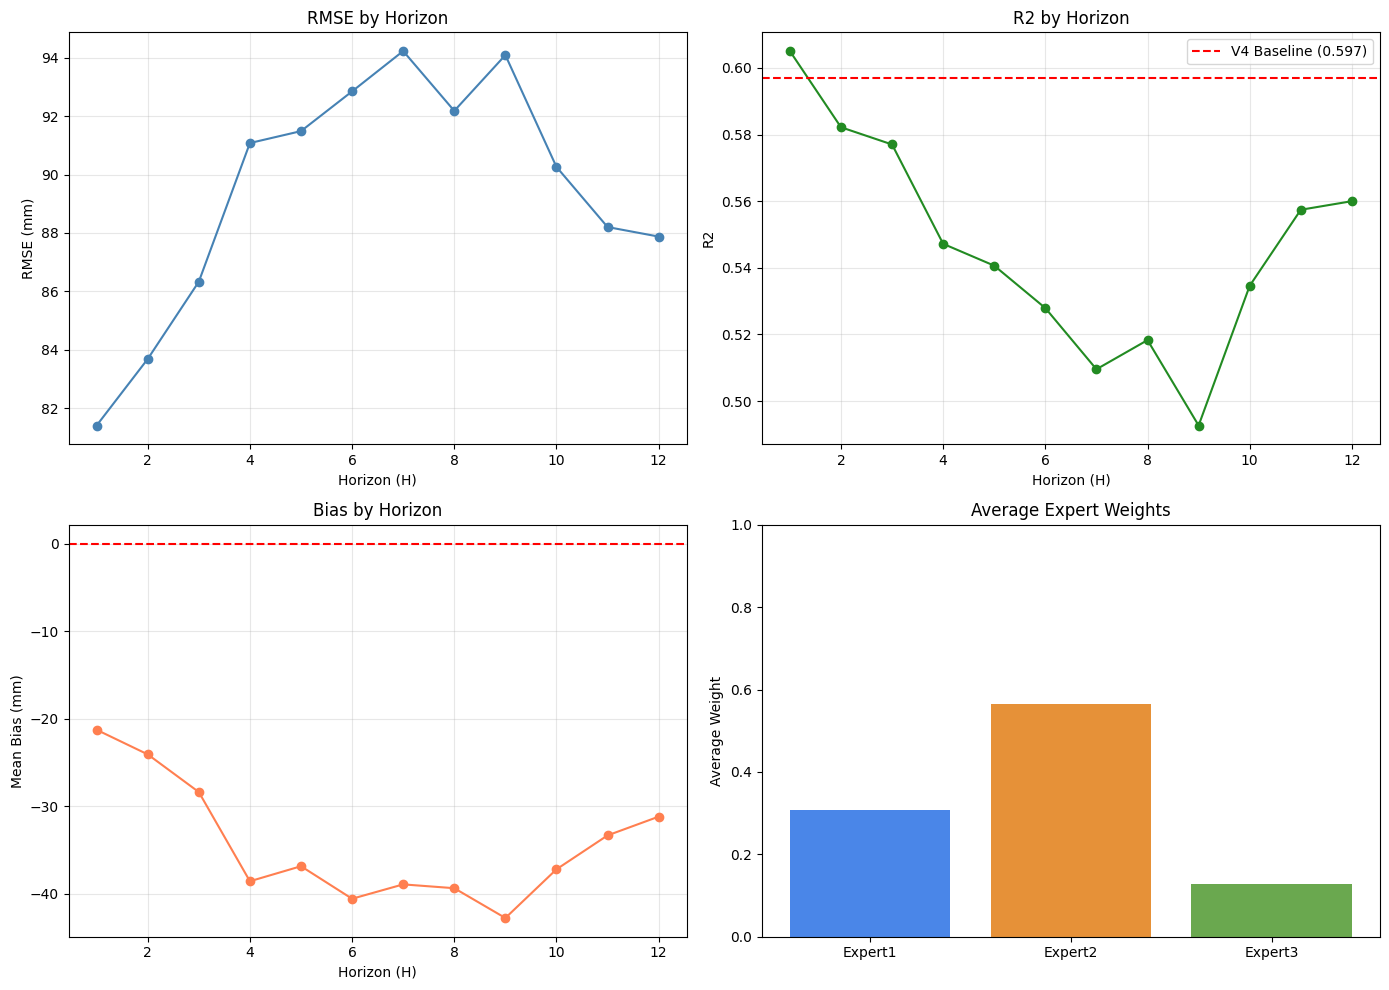

Results plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/v7_results_summary.png


In [17]:
# =============================================================================
# SECTION 9.1: RESULTS OVERVIEW
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_v7_results(metrics_df: pd.DataFrame, experiment_state: Dict, output_dir: Path):
    if metrics_df is None or len(metrics_df) == 0:
        print("No metrics to plot")
        return

    horizons = sorted(metrics_df['H'].unique())
    rmse_by_h = metrics_df.groupby('H')['RMSE'].mean()
    r2_by_h = metrics_df.groupby('H')['R^2'].mean()
    bias_by_h = metrics_df.groupby('H')['mean_bias_mm'].mean()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    ax1.plot(horizons, rmse_by_h.values, marker='o', color='steelblue')
    ax1.set_xlabel('Horizon (H)')
    ax1.set_ylabel('RMSE (mm)')
    ax1.set_title('RMSE by Horizon')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    ax2.plot(horizons, r2_by_h.values, marker='o', color='forestgreen')
    ax2.set_xlabel('Horizon (H)')
    ax2.set_ylabel('R2')
    ax2.set_title('R2 by Horizon')
    ax2.axhline(y=0.597, color='red', linestyle='--', label='V4 Baseline (0.597)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(horizons, bias_by_h.values, marker='o', color='coral')
    ax3.axhline(0, color='red', linestyle='--')
    ax3.set_xlabel('Horizon (H)')
    ax3.set_ylabel('Mean Bias (mm)')
    ax3.set_title('Bias by Horizon')
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    weights_list = []
    for exp_name, exp_results in experiment_state.get('results', {}).items():
        for h_key, results in exp_results.items():
            metrics = results.get('metrics', {})
            if 'expert_weights' in metrics:
                w = metrics['expert_weights']
                weights_list.append([w['w_expert1'], w['w_expert2'], w['w_expert3']])

    if weights_list:
        avg_weights = np.mean(weights_list, axis=0)
        ax4.bar(['Expert1', 'Expert2', 'Expert3'], avg_weights, color=['#4a86e8', '#e69138', '#6aa84f'])
        ax4.set_ylim(0, 1)
        ax4.set_ylabel('Average Weight')
        ax4.set_title('Average Expert Weights')
    else:
        ax4.text(0.5, 0.5, 'No expert weights available', ha='center', va='center')
        ax4.set_axis_off()

    plt.tight_layout()

    fig_path = output_dir / 'v7_results_summary.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Results plot saved to: {fig_path}")


plot_v7_results(metrics_df, experiment_state, OUTPUT_ROOT)


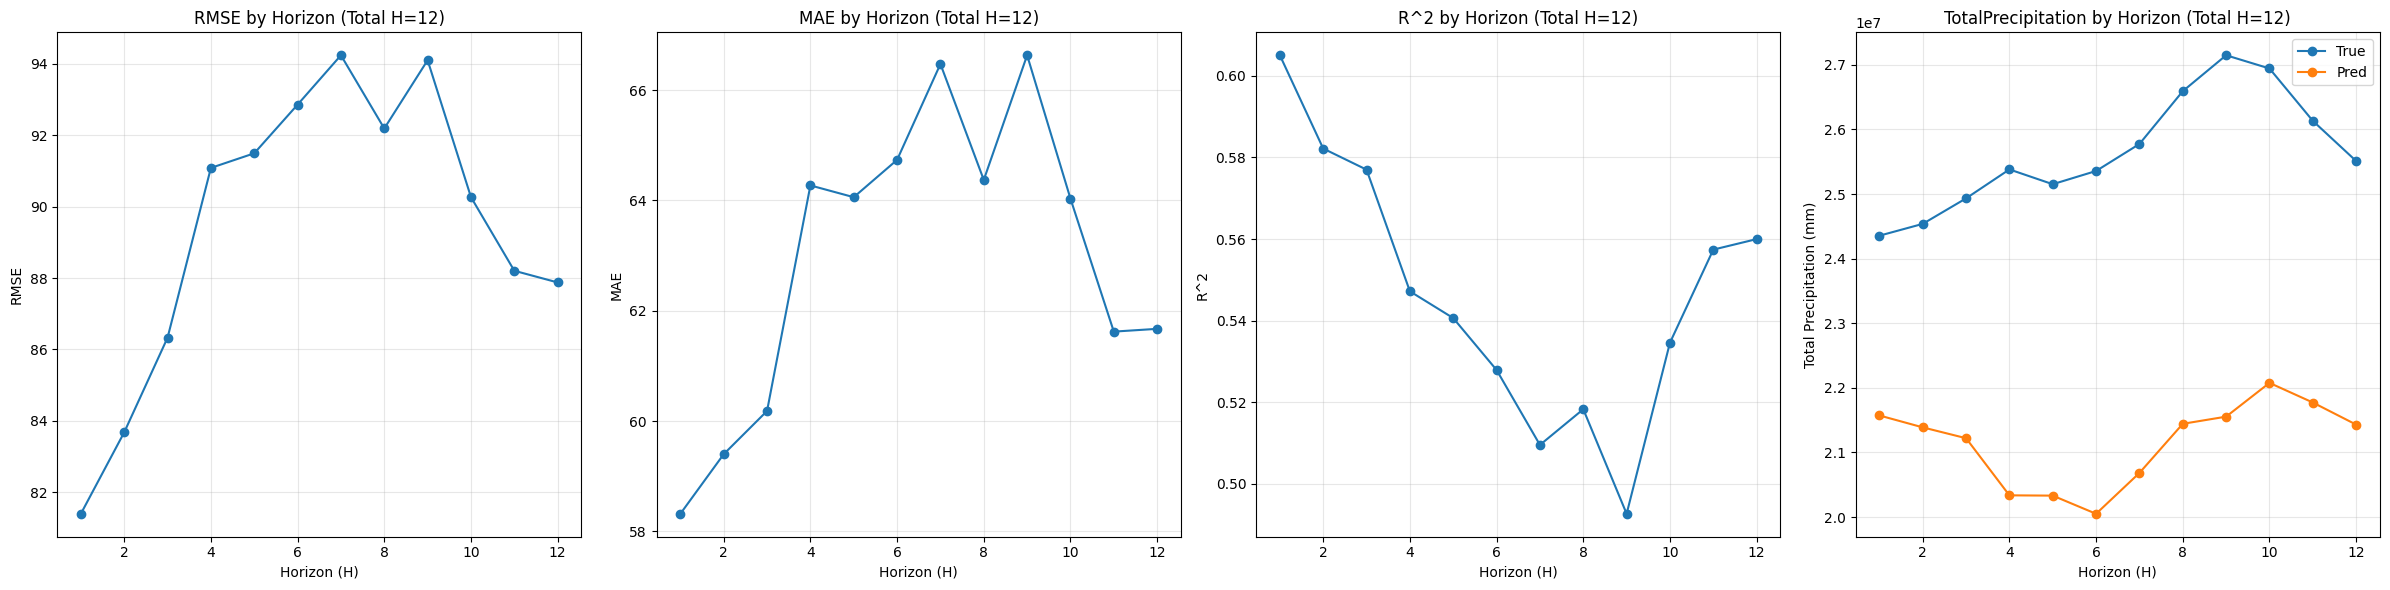

Evolution plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/comparisons/v7_evolution_h12.png


In [18]:
# =============================================================================
# SECTION 9.1: METRICS EVOLUTION BY HORIZON
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_v7_evolution_by_horizon(metrics_df: pd.DataFrame, output_dir: Path):
    if metrics_df is None or metrics_df.empty:
        print('No metrics to plot for evolution panels')
        return

    metrics = ['RMSE', 'MAE', 'R^2']
    has_tp = 'TotalPrecipitation' in metrics_df.columns and 'TotalPrecipitation_Pred' in metrics_df.columns
    if has_tp:
        metrics.append('TotalPrecipitation')

    for total_h in sorted(metrics_df['TotalHorizon'].unique()):
        sub_df = metrics_df[metrics_df['TotalHorizon'] == total_h].copy()
        fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 6))
        if len(metrics) == 1:
            axes = [axes]

        for metric, ax in zip(metrics, axes):
            if metric == 'TotalPrecipitation':
                ax.plot(sub_df['H'], sub_df['TotalPrecipitation'], label='True', marker='o')
                ax.plot(sub_df['H'], sub_df['TotalPrecipitation_Pred'], label='Pred', marker='o')
                ax.set_ylabel('Total Precipitation (mm)')
            else:
                ax.plot(sub_df['H'], sub_df[metric], marker='o')
                ax.set_ylabel(metric)
            ax.set_xlabel('Horizon (H)')
            ax.set_title(f'{metric} by Horizon (Total H={total_h})')
            ax.grid(True, alpha=0.3)
            if metric == 'TotalPrecipitation':
                ax.legend()

        fig_path = output_dir / f'v7_evolution_h{total_h}.png'
        plt.tight_layout()
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Evolution plot saved to: {fig_path}")


if metrics_df is not None and len(metrics_df) > 0:
    plot_v7_evolution_by_horizon(metrics_df, COMP_DIR)


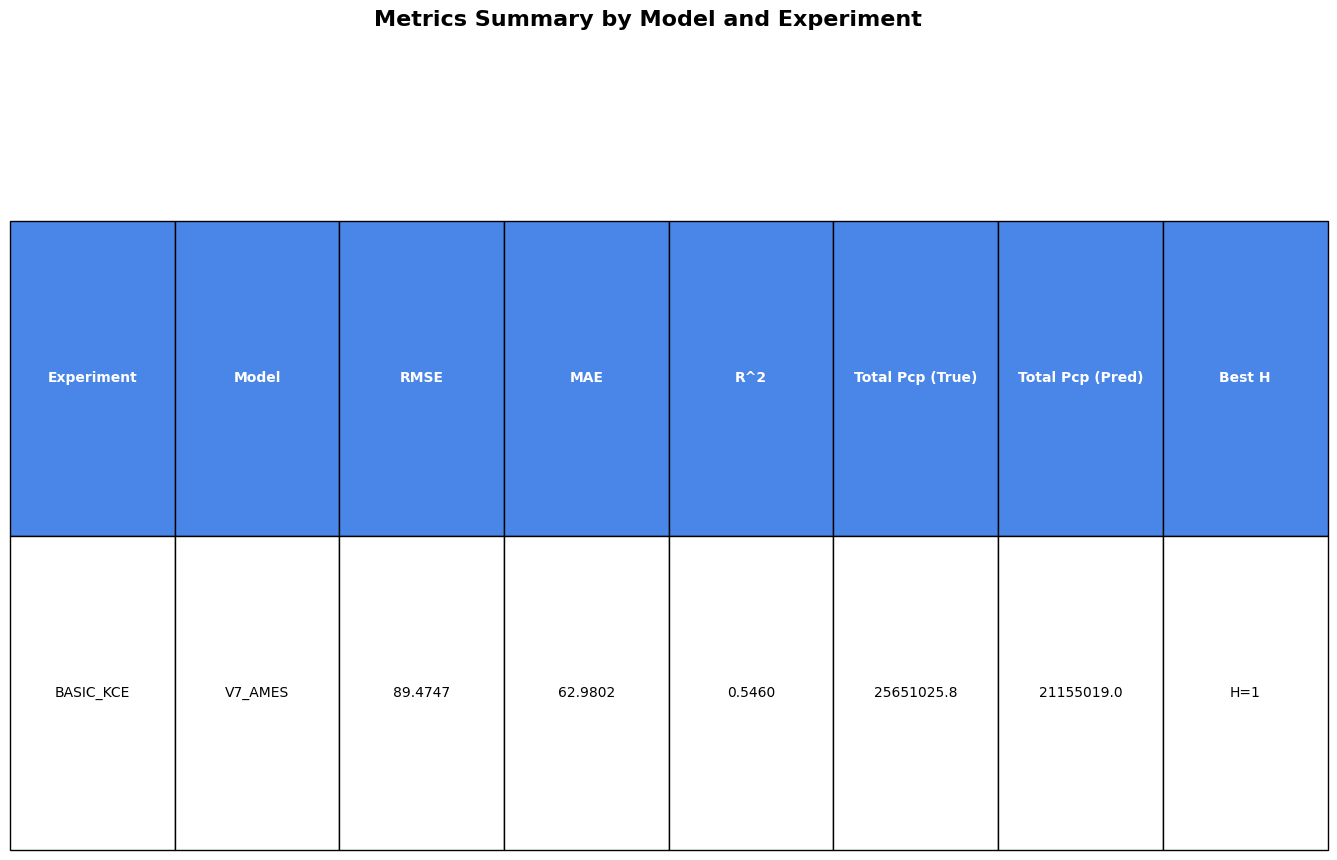

Metrics summary table saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/comparisons/v7_metrics_summary_table.png


In [19]:
# =============================================================================
# SECTION 9.2: METRICS TABLE
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_v7_metrics_table(metrics_df: pd.DataFrame, output_dir: Path):
    if metrics_df is None or metrics_df.empty:
        print('No metrics available to build summary table')
        return

    has_tp = 'TotalPrecipitation' in metrics_df.columns and 'TotalPrecipitation_Pred' in metrics_df.columns

    summary_data = []
    experiments = metrics_df['Experiment'].unique()
    models = metrics_df['Model'].unique()
    headers = ['Experiment', 'Model', 'RMSE', 'MAE', 'R^2', 'Total Pcp (True)', 'Total Pcp (Pred)', 'Best H']

    for exp in experiments:
        for model in models:
            sub = metrics_df[(metrics_df['Experiment'] == exp) & (metrics_df['Model'] == model)]
            if sub.empty:
                continue
            avg_rmse = sub['RMSE'].mean()
            avg_mae = sub['MAE'].mean()
            avg_r2 = sub['R^2'].mean()
            if has_tp:
                avg_tp_t = sub['TotalPrecipitation'].mean()
                avg_tp_p = sub['TotalPrecipitation_Pred'].mean()
            else:
                avg_tp_t = float('nan')
                avg_tp_p = float('nan')
            best_h = sub.loc[sub['RMSE'].idxmin(), 'H']
            summary_data.append([
                exp, model,
                f'{avg_rmse:.4f}', f'{avg_mae:.4f}', f'{avg_r2:.4f}',
                f'{avg_tp_t:.1f}' if has_tp else 'n/a',
                f'{avg_tp_p:.1f}' if has_tp else 'n/a',
                f'H={best_h}'
            ])

    fig, ax = plt.subplots(figsize=(17, 10))
    ax.axis('off')
    table = ax.table(cellText=summary_data, colLabels=headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 0.85])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.15, 1.8)

    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    fig.suptitle('Metrics Summary by Model and Experiment', fontsize=16, fontweight='bold', y=0.95)
    plt.subplots_adjust(top=0.85)
    fig_path = output_dir / 'v7_metrics_summary_table.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', pad_inches=0.5)
    plt.show()

    if summary_data:
        print('Metrics summary table saved to:', fig_path)


if metrics_df is not None and len(metrics_df) > 0:
    plot_v7_metrics_table(metrics_df, COMP_DIR)


Comparison plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/comparisons/model_comparison_v7_ames.png


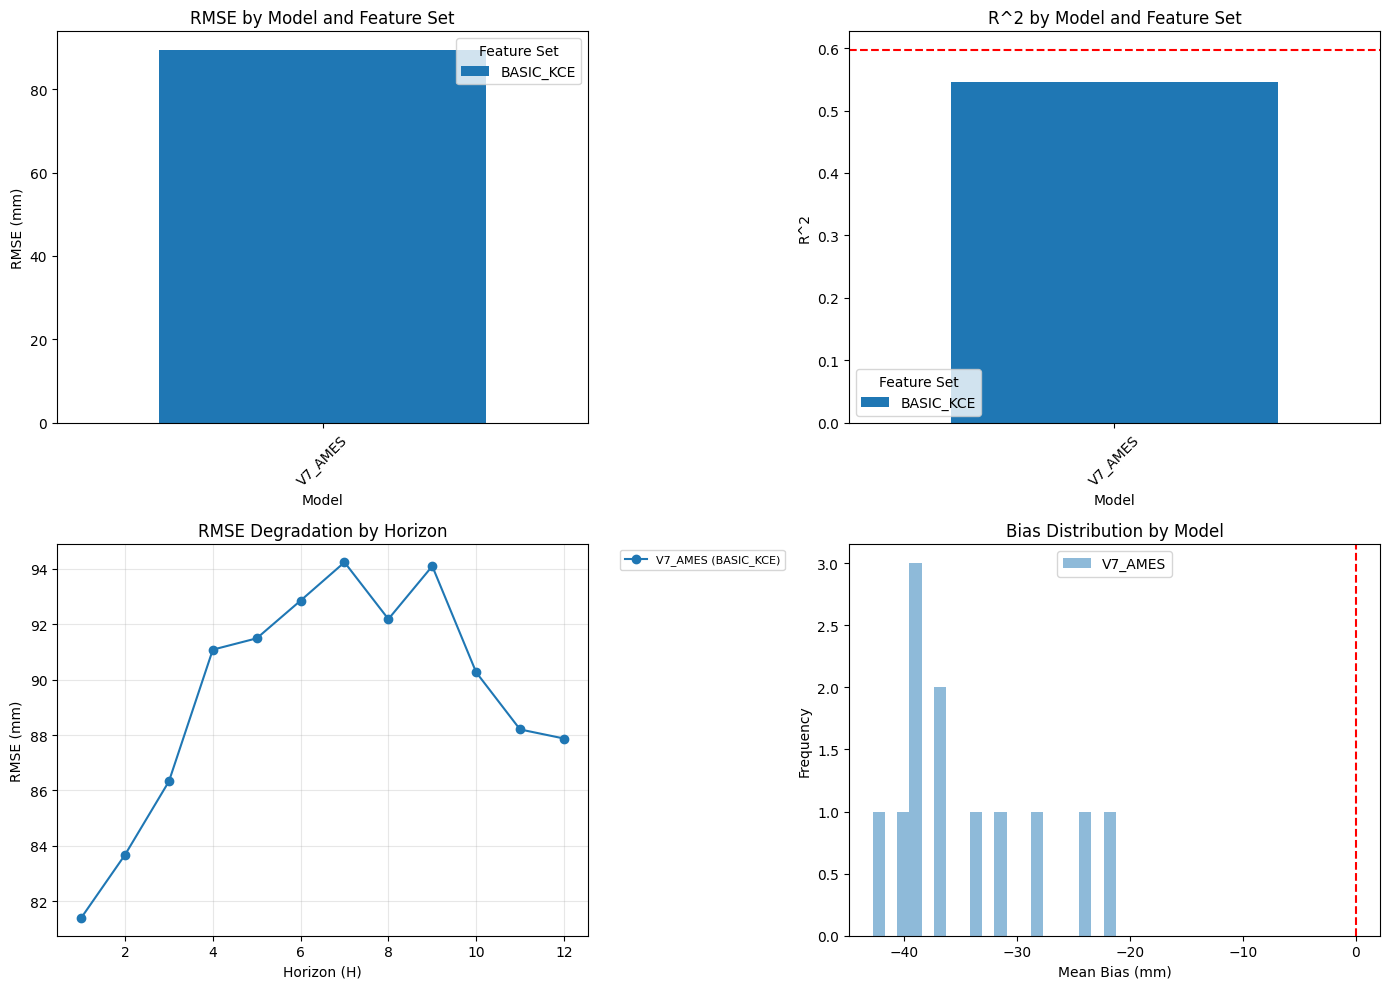

In [20]:
# =============================================================================
# SECTION 9.3: MODEL COMPARISON
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_model_comparison_v7(res_df: pd.DataFrame, output_dir: Path):
    if res_df is None or res_df.empty:
        print('No results to plot for model comparison')
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    pivot_rmse = res_df.groupby(['Model', 'Experiment'])['RMSE'].mean().unstack()
    pivot_rmse.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_ylabel('RMSE (mm)')
    ax1.set_title('RMSE by Model and Feature Set')
    ax1.legend(title='Feature Set')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = axes[0, 1]
    pivot_r2 = res_df.groupby(['Model', 'Experiment'])['R^2'].mean().unstack()
    pivot_r2.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_ylabel('R^2')
    ax2.set_title('R^2 by Model and Feature Set')
    ax2.legend(title='Feature Set')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=0.597, color='red', linestyle='--', label='V4 Baseline (0.597)')

    ax3 = axes[1, 0]
    for model in res_df['Model'].unique():
        model_data = res_df[res_df['Model'] == model]
        for exp in model_data['Experiment'].unique():
            exp_data = model_data[model_data['Experiment'] == exp]
            ax3.plot(exp_data['H'], exp_data['RMSE'], marker='o', label=f"{model} ({exp})")
    ax3.set_xlabel('Horizon (H)')
    ax3.set_ylabel('RMSE (mm)')
    ax3.set_title('RMSE Degradation by Horizon')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    for model in res_df['Model'].unique():
        model_bias = res_df[res_df['Model'] == model]['mean_bias_mm']
        ax4.hist(model_bias, bins=20, alpha=0.5, label=model)
    ax4.axvline(x=0, color='red', linestyle='--')
    ax4.set_xlabel('Mean Bias (mm)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Bias Distribution by Model')
    ax4.legend()

    plt.tight_layout()

    fig_path = output_dir / 'model_comparison_v7_ames.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Comparison plot saved to: {fig_path}")
    plt.show()


if metrics_df is not None and len(metrics_df) > 0:
    plot_model_comparison_v7(metrics_df, COMP_DIR)


In [21]:
# =============================================================================
# SECTION 9.4: MAP EXPORTS
# =============================================================================

SHAPE_DIR = BASE_PATH / 'data' / 'input' / 'shapes'


def _load_boyaca_shape(shape_dir: Path):
    if gpd is None:
        print('geopandas not available; overlay disabled')
        return None, None
    if not shape_dir.exists():
        print(f"[WARN] Shape directory not found: {shape_dir}")
        return None, None

    shp_path = shape_dir / 'MGN_Departamento.shp'
    try:
        dept_gdf = gpd.read_file(shp_path)
    except Exception as exc:
        print(f"[WARN] Failed to read shapefile {shp_path}: {exc}")
        return None, None

    if dept_gdf is None or dept_gdf.empty:
        print(f"[WARN] Shapefile is empty: {shp_path}")
        return dept_gdf, None

    col_candidates = [c for c in dept_gdf.columns if c.lower() in {
        'nombre_dpt', 'nombre_dept', 'nombre', 'departamen', 'dpto'
    }]
    boyaca = None
    if col_candidates:
        name_col = col_candidates[0]
        boyaca = dept_gdf[dept_gdf[name_col].astype(str).str.upper().str.contains('BOYACA', na=False)].copy()
    elif len(dept_gdf) == 1:
        boyaca = dept_gdf.copy()
        print('[INFO] No name column found; assuming single feature is Boyaca')
    else:
        print(f"[WARN] Could not identify Boyaca geometry; columns present: {list(dept_gdf.columns)}")

    if boyaca is not None and boyaca.empty:
        print('[WARN] Boyaca geometry not found in shapefile; overlay disabled')
        boyaca = None

    return dept_gdf, boyaca


DEPT_GDF, BOYACA = _load_boyaca_shape(SHAPE_DIR)

MAP_OUT_ROOT = OUTPUT_ROOT / 'map_exports'
PLOT_HORIZONS = CONFIG.enabled_horizons or [CONFIG.horizon]
PLOT_EXPERIMENTS = [exp['name'] for exp in EXPERIMENTS] if 'EXPERIMENTS' in globals() else ['BASIC_KCE']
PLOT_MODELS = ['V7_AMES']
MAP_SAMPLE_INDEX = CONFIG.map_sample_index
CYCLE_ALL_VAL_WINDOWS = CONFIG.map_cycle_all_val_windows
EXPORT_DPI = CONFIG.map_export_dpi
GIF_FRAME_DURATION = CONFIG.map_gif_duration
MAP_MAX_WINDOWS = None

lats = DS[LAT_DIM].values
lons = DS[LON_DIM].values
EXTENT = [float(lons.min()), float(lons.max()), float(lats.min()), float(lats.max())]


def _load_exports(exp_name: str, model_name: str, horizon: int):
    export_dir = MAP_OUT_ROOT / f'H{horizon}' / exp_name / model_name
    pred_f = export_dir / 'predictions.npy'
    targ_f = export_dir / 'targets.npy'
    meta_f = export_dir / 'metadata.json'
    if not (pred_f.exists() and targ_f.exists() and meta_f.exists()):
        return None, None, None, None
    y_pred = np.load(pred_f)
    y_true = np.load(targ_f)
    meta = json.loads(meta_f.read_text())
    if y_pred.ndim == 5:
        y_pred = y_pred[..., 0]
    if y_true.ndim == 5:
        y_true = y_true[..., 0]
    return y_pred, y_true, meta, export_dir


def _plot_triplet(ax, data, title, cmap, vmin=None, vmax=None):
    im = ax.imshow(data, origin='lower', extent=EXTENT, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    return im


def plot_maps_v7():
    if not MAP_OUT_ROOT.exists():
        print(f"Map export root not found: {MAP_OUT_ROOT}")
        return
    if imageio is None:
        print('imageio not available; GIF export disabled')

    for horizon in PLOT_HORIZONS:
        for exp_name in PLOT_EXPERIMENTS:
            for model_name in PLOT_MODELS:
                y_pred, y_true, meta, export_dir = _load_exports(exp_name, model_name, horizon)
                if y_pred is None:
                    print(f"[SKIP] {exp_name} - {model_name} - H{horizon}: exports not found")
                    continue

                if CYCLE_ALL_VAL_WINDOWS:
                    indices_to_plot = range(len(y_true))
                else:
                    idx = MAP_SAMPLE_INDEX if MAP_SAMPLE_INDEX >= 0 else (len(y_true) - 1)
                    idx = max(min(idx, len(y_true) - 1), 0)
                    indices_to_plot = [idx]

                if MAP_MAX_WINDOWS is not None:
                    indices_to_plot = list(indices_to_plot)[:MAP_MAX_WINDOWS]

                forecast_dates = meta.get('forecast_dates', [])
                if not forecast_dates and meta.get('val_indices'):
                    forecast_dates = _forecast_dates(DS, meta['val_indices'], CONFIG.input_window, horizon)

                frame_count = 0
                gif_path = export_dir / f'{model_name}_H{horizon}.gif'
                writer = None

                for idx in indices_to_plot:
                    sample_dates = forecast_dates[idx] if idx < len(forecast_dates) else []
                    for h in range(min(horizon, len(sample_dates) or horizon)):
                        real = y_true[idx, h]
                        pred = y_pred[idx, h]
                        err = np.abs(pred - real) / (np.abs(real) + 1e-6) * 100.0

                        fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
                        date_label = sample_dates[h] if h < len(sample_dates) else f'H{h + 1}'
                        im0 = _plot_triplet(axes[0], real, f'Real {date_label}', 'Blues')
                        im1 = _plot_triplet(axes[1], pred, f'{model_name} H{h + 1} {date_label}', 'Blues')
                        im2 = _plot_triplet(axes[2], np.clip(err, 0, 100), f'MAPE% {model_name} H{h + 1} {date_label}', 'Reds', vmin=0, vmax=100)
                        if BOYACA is not None:
                            try:
                                BOYACA.boundary.plot(ax=axes[0], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[1], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[2], color='k', linewidth=0.8)
                            except Exception as exc:
                                print(f"[WARN] shapefile overlay failed: {exc}")

                        cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
                        cbar0.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
                        cbar1.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
                        cbar2.set_label('MAPE (%)', rotation=270, labelpad=12)

                        title = f'{exp_name} | {model_name} | H{horizon} | {date_label}'
                        fig.suptitle(title, fontsize=12)

                        export_dir.mkdir(parents=True, exist_ok=True)
                        png_path = export_dir / f'{model_name}_H{horizon}_{date_label}.png'
                        fig.savefig(png_path, dpi=EXPORT_DPI)
                        plt.close(fig)

                        if imageio is not None:
                            frame = imageio.imread(png_path)
                            if writer is None:
                                writer = imageio.get_writer(gif_path, mode='I', duration=GIF_FRAME_DURATION, loop=0)
                            writer.append_data(frame)
                            del frame

                        frame_count += 1
                        del real, pred, err

                if writer is not None:
                    writer.close()

                print(f"[OK] {exp_name} - {model_name} - H{horizon}: saved {frame_count} frames to {export_dir}")


if getattr(CONFIG, 'generate_map_plots', True):
    plot_maps_v7()
else:
    print('Map plot generation disabled')


[INFO] No name column found; assuming single feature is Boyaca
[OK] BASIC_KCE - V7_AMES - H12: saved 12 frames to /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/map_exports/H12/BASIC_KCE/V7_AMES


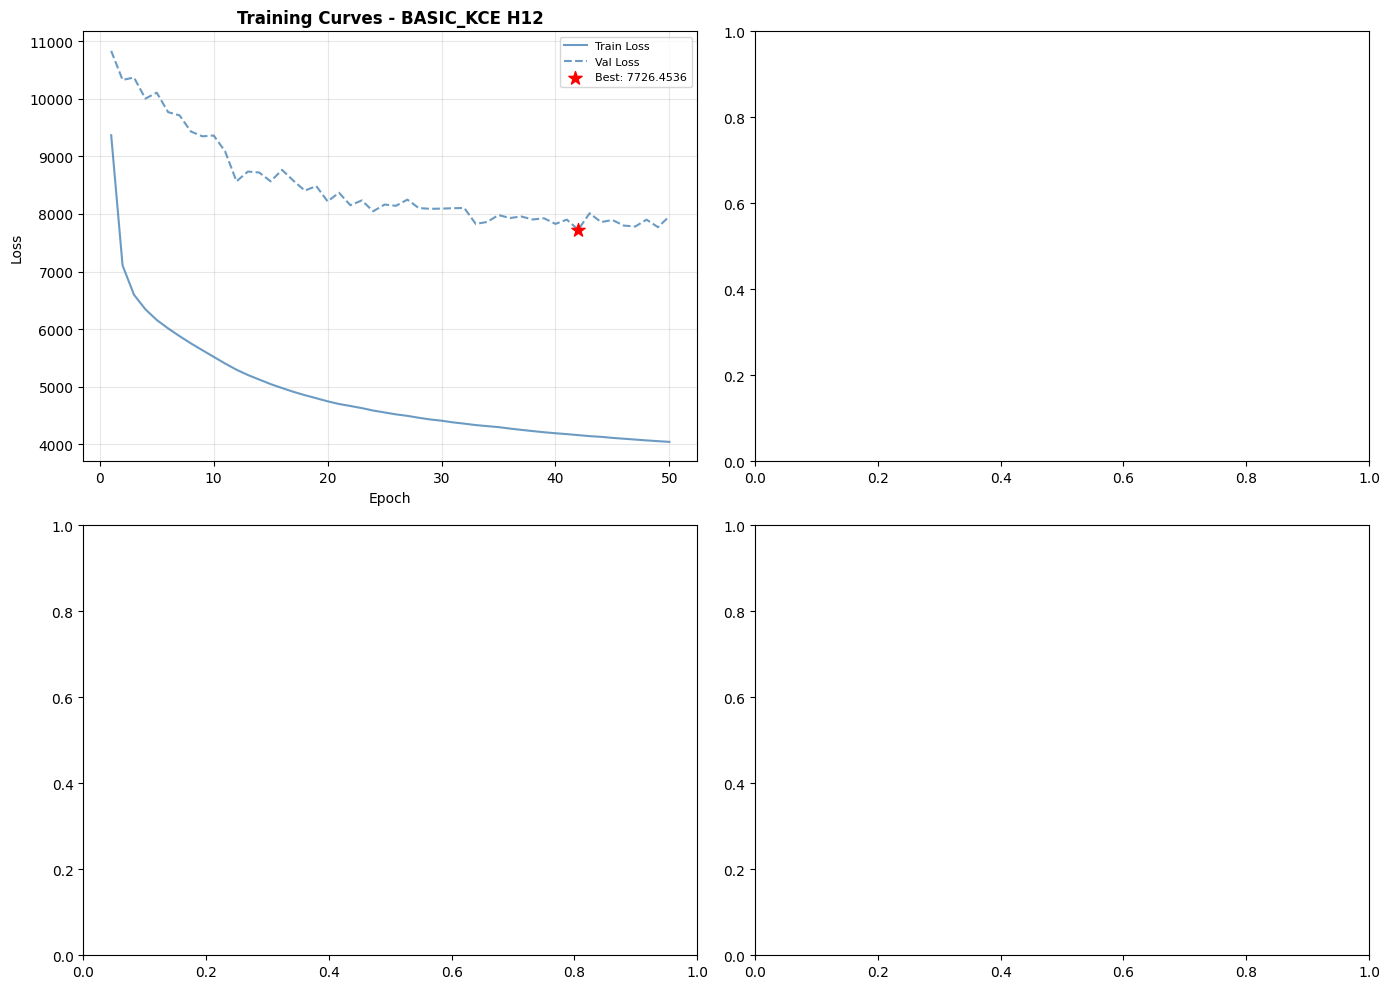

Training curves saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V7_AMES/v7_training_curves.png


In [22]:
# =============================================================================
# SECTION 9.5: TRAINING CURVES VISUALIZATION
# =============================================================================

def plot_training_curves(experiment_state: Dict, output_dir: Path):
    """Plot training curves for all horizons."""

    entries = []
    for exp_name, exp_results in experiment_state.get('results', {}).items():
        for h_key, results in exp_results.items():
            entries.append((exp_name, h_key, results))

    if not entries:
        print("No training results to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    colors = ['steelblue', 'coral', 'forestgreen', 'purple']

    for idx, (exp_name, h_key, results) in enumerate(entries[:4]):
        ax = axes[idx]

        h_num = h_key.replace('H', '')
        log_path = output_dir / f'h{h_num}' / exp_name / 'training_metrics' / f'v7_training_log_h{h_num}.csv'

        if log_path.exists():
            log_df = pd.read_csv(log_path)

            ax.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', color=colors[idx], alpha=0.8)
            ax.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', color=colors[idx], linestyle='--', alpha=0.8)

            best_epoch = log_df['val_loss'].idxmin() + 1
            best_val = log_df['val_loss'].min()
            ax.scatter([best_epoch], [best_val], color='red', s=100, zorder=5, marker='*', label=f'Best: {best_val:.4f}')

        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.set_title(f'Training Curves - {exp_name} {h_key}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    plt.tight_layout()

    fig_path = output_dir / 'v7_training_curves.png'
    fig.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"Training curves saved to: {fig_path}")

# Plot training curves
plot_training_curves(experiment_state, OUTPUT_ROOT)


## 10. Summary and Next Steps


In [23]:
# =============================================================================
# SECTION 10: SUMMARY AND RESULTS
# =============================================================================

print("" + "="*70)
print("V7-AMES - EXPERIMENT SUMMARY")
print("="*70)

# Print configuration
print("[Configuration]")
print(f"  Light Mode: {CONFIG.light_mode}")
if CONFIG.light_mode:
    print(f"  Grid Size: {CONFIG.light_grid_size}x{CONFIG.light_grid_size}")
print(f"  GNN Type: {CONFIG.gnn_type}")
print(f"  Horizons: {CONFIG.enabled_horizons}")
print(f"  Stage 1 Epochs: {CONFIG.epochs_stage1}")
print(f"  Stage 2 Epochs: {CONFIG.epochs_stage2}")
print(f"  Stage 3 Epochs: {CONFIG.epochs_stage3}")
print(f"  Batch Size: {CONFIG.batch_size}")
if 'EXPERIMENTS' in globals():
    exp_names = [exp['name'] for exp in EXPERIMENTS]
    print(f"  Experiments: {', '.join(exp_names)}")
if 'data_report' in globals() and data_report:
    print(f"  Split Mode: {data_report.get('split_mode', 'unknown')}")
    print(f"  Split Index: {data_report.get('split_time_idx', 'unknown')}")

# Print results summary
if metrics_df is not None and len(metrics_df) > 0:
    print("[Results Summary]")
    print("-"*70)
    print(metrics_df[['TotalHorizon', 'H', 'RMSE', 'MAE', 'R^2', 'mean_bias_mm']].to_string(index=False))
    print("-"*70)

    # Overall averages
    print("[Overall Averages]")
    print(f"  RMSE: {metrics_df['RMSE'].mean():.2f} mm")
    print(f"  MAE: {metrics_df['MAE'].mean():.2f} mm")
    print(f"  R2: {metrics_df['R^2'].mean():.4f}")
    print(f"  Bias: {metrics_df['mean_bias_mm'].mean():.2f} mm")

# Expert weights
print("[Expert Weights (Gating)]")
for exp_name, exp_results in experiment_state.get('results', {}).items():
    for h_key, results in exp_results.items():
        metrics = results.get('metrics', {})
        if 'expert_weights' in metrics:
            w = metrics['expert_weights']
            print(f"  {exp_name} {h_key}: E1={w['w_expert1']:.1%}, E2={w['w_expert2']:.1%}, E3={w['w_expert3']:.1%}")
        if 'alpha' in metrics:
            print(f"  {exp_name} {h_key}: alpha={metrics['alpha']:.3f}")

# Quality checks
print("[Quality Checks]")
for exp_name, exp_results in experiment_state.get('results', {}).items():
    for h_key, results in exp_results.items():
        qc = results.get('quality_checks', {})
        issues = qc.get('issues', [])
        status = 'OK' if not issues else f"WARN: {', '.join(issues)}"
        print(f"  {exp_name} {h_key}: {status}")

# Output files
print("[Output Files]")
print(f"  Output Directory: {OUTPUT_ROOT}")
for path in OUTPUT_ROOT.glob('*'):
    if path.is_file():
        print(f"  - {path.name}")

# Next steps
print("[Next Steps]")
if CONFIG.light_mode:
    print("  1. Set light_mode=False for full grid validation (61x65)")
    print("  2. Run full experiments on Colab GPU")
print("  3. Run ablation studies (disable physics loss or gating)")
print("  4. Compare results with V4 baseline (R2=0.597, RMSE=84.40mm)")


SyntaxError: unterminated string literal (detected at line 5) (ipython-input-3694622935.py, line 5)

In [ ]:
# =============================================================================
# SECTION 10.2: CLEANUP
# =============================================================================

# Memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory freed. Current usage: {torch.cuda.memory_allocated() / 1e6:.1f} MB")

print("Notebook execution completed successfully.")


In [ ]:
print(sys.version)
print(torch.__version__)
print(torch.version.cuda)